# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Transactional data is provided, which is showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Problem Statement 

Starbucks demands an intelligent model deciding whether to show the online offer or not to each individual customer. Moreover, the company also wants to show the best offer to them, increasing the offer acceptance probability. 

To deal with this problem, we are going to use the customers historical data and build a model. Performance evaluation of the model can be made by observing the past offers and their acceptance and rejection states. The solution will be based on the demographic features, the behavioral features and also the promotion features.

## Solution Design

In the ML perspective, a model will be developed deciding the end result of the offer when a customer receives an offer. 

In general, there are three cases:
- Customer receives, views and completes the offer.                   
    - **Class 0:** Offer Received -> Offer Viewed -> Offer Completed
- Customer receives and views the offer, but does not complete it.
    - **Class 1:** Offer Received -> Offer Viewed
- Customer receives the offer but does not neither view or complete it.
    - **Class 2:** Offer Received

## Assumptions

The main goal will be a classification problem. By using the given data sets, the feature set will be engineered in consistent with the cases above. In other words:
- To complete an offer, a customer should receive and view the offer, respectively.
- Offer states should be aligned on the time. A customer cannot view offer before receiving it.
- Once an offer is viewed or completed, then the same offer cannot be viewed and completed again.
- A customer can receive the same offer in different times, this cancels the offer had sent in the past.
- If the customer receives and completes an offer without viewing, view time is assumed as the same as completion time.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Data Exploration - Portfolio & Profile

In [1]:
import pandas as pd
import numpy as np
import math
import json
import pickle

%matplotlib inline
pd.set_option("display.max_rows", 200)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
portfolio = pd.read_json('../data/raw/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../data/raw/profile.json', orient='records', lines=True)
transcript = pd.read_json('../data/raw/transcript.json', orient='records', lines=True)

## Portfolio

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# reorder and rename columns
portfolio_ = portfolio[["id", "offer_type", "difficulty", "duration", "reward", "channels"]]
portfolio_ = portfolio_.rename(columns={"id":"offer_id"})

portfolio_.head()

,offer_id,offer_type,difficulty,duration,reward,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,"[email, mobile, social]"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,"[web, email, mobile, social]"
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,0,"[web, email, mobile]"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,"[web, email, mobile]"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,"[web, email]"


In [5]:
# Channels are stored as list in channels column. Explode the list variables as dataframe variables.
for col in ["web", "email", "mobile", "social"]:
    portfolio_[col] = portfolio_["channels"].apply(lambda x: 1 if col in x else 0)
    
portfolio_.head()

,offer_id,offer_type,difficulty,duration,reward,channels,web,email,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,"[email, mobile, social]",0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,"[web, email, mobile, social]",1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,0,"[web, email, mobile]",1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,"[web, email, mobile]",1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,"[web, email]",1,1,0,0


In [6]:
portfolio_.describe()

,difficulty,duration,reward,web,email,mobile,social
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,7.700000,6.500000,4.200000,0.800000,1.0,0.900000,0.600000
std,5.831905,2.321398,3.583915,0.421637,0.0,0.316228,0.516398
min,0.000000,3.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,5.000000,5.000000,2.000000,1.000000,1.0,1.000000,0.000000
50%,8.500000,7.000000,4.000000,1.000000,1.0,1.000000,1.000000
75%,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000
max,20.000000,10.000000,10.000000,1.000000,1.0,1.000000,1.000000


- We have channels information as binary variables. Also, email variable is constant. Drop **channels** and **email** columns.

In [7]:
portfolio_ = portfolio_.drop(columns=["channels", "email"], axis=1)
portfolio_.head()

,offer_id,offer_type,difficulty,duration,reward,web,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,0,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,0,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,1,0,0


In [8]:
# check the number of distinct ids
portfolio_["offer_id"].nunique()

10

### Exploration

In [9]:
df = portfolio_.set_index("offer_id").copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, ae264e3637204a6fb9bb56bc8210ddfd to 2906b810c7d4411798c6938adc9daaa5
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   offer_type  10 non-null     object
 1   difficulty  10 non-null     int64 
 2   duration    10 non-null     int64 
 3   reward      10 non-null     int64 
 4   web         10 non-null     int64 
 5   mobile      10 non-null     int64 
 6   social      10 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 640.0+ bytes


In [10]:
df.sort_values(["offer_type", "difficulty"])

,offer_type,difficulty,duration,reward,web,mobile,social
offer_id,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,1,1,0
f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,1,1,1
ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,0,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,1,1,1
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,1,1,1
2906b810c7d4411798c6938adc9daaa5,discount,10,7,2,1,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,1,0,0
3f207df678b143eea3cee63160fa8bed,informational,0,4,0,1,1,0


##### Comments

- **portfolio** has **10** records with **7** feature columns and **1** index column.
- Although the variables are numeric, they are not continuous, but categorical.
- Categorical variables need encoding. Also, they may cause high correlation in the model dataset. 
    - Example: _mobile = 0_ only when _offer_type = 'discount'_ and _difficulty = 20_. In this case, if _mobile = 0_, then it is already known that _difficulty = 20_.

## Profile

In [11]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
# reorder and rename columns
profile_ = profile[["id", "became_member_on", "age", "gender", "income"]]
profile_ = profile_.rename(columns={"id":"customer_id"})
profile_.head()

,customer_id,became_member_on,age,gender,income
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,118,None,NaN
1,0610b486422d4921ae7d2bf64640c50b,20170715,55,F,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,118,None,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,20170509,75,F,100000.0
4,a03223e636434f42ac4c3df47e8bac43,20170804,118,None,NaN


In [13]:
# check the number of distinct ids
profile_["customer_id"].nunique()

17000

### Exploration

In [14]:
df = profile_.set_index("customer_id").copy()

### Analysis on NULL Profiles

In [15]:
cols = ["became_member_on", "gender", "age", "income"]

for col in cols:
    print("{:20}".format(col), ":", (~df[col].isnull()).sum())

became_member_on     : 17000
gender               : 14825
age                  : 17000
income               : 14825


In [16]:
cols = ["gender", "income"]
counts = df[cols].astype(str).groupby(cols).size().rename("count").reset_index()
counts.sort_values("count", ascending=False).head()

,gender,income,count
182,None,nan,2175
134,M,52000.0,185
155,M,73000.0,183
138,M,56000.0,181
135,M,53000.0,179


- There are **17000** records, those have **2175** NULL values on gender and income. NULL values occurs on the same records. Examine those records.

In [17]:
# print head of null values
df[df["gender"].isnull()].head()

,became_member_on,age,gender,income
customer_id,,,,
68be06ca386d4c31939f3a4f0e3dd783,20170212,118,None,NaN
38fe809add3b4fcf9315a9694bb96ff5,20180712,118,None,NaN
a03223e636434f42ac4c3df47e8bac43,20170804,118,None,NaN
8ec6ce2a7e7949b1bf142def7d0e0586,20170925,118,None,NaN
68617ca6246f4fbc85e91a2a49552598,20171002,118,None,NaN


In [18]:
# print age counts
df.loc[df["gender"].isnull(), "age"].value_counts()

118    2175
Name: age, dtype: int64

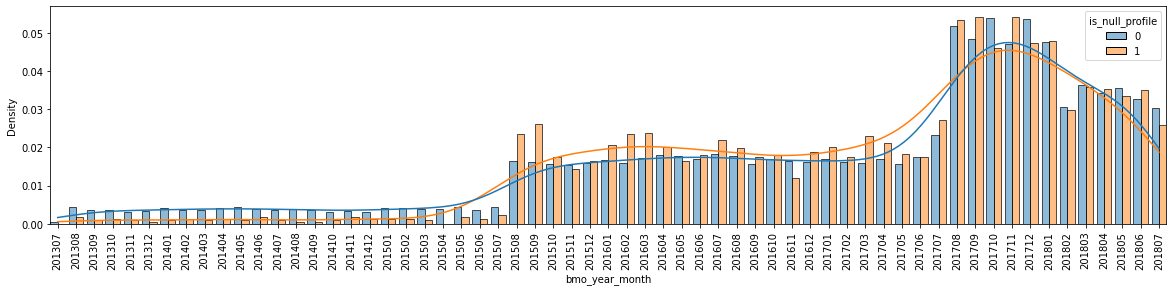

In [19]:
### plot became_member_on as barchart

# monthly bucketing
df["bmo_year_month"] = df["became_member_on"].astype(str).str.slice(0, 6)

# indicate a customer has NULL values or not
df["is_null_profile"] = df["gender"].isnull().astype(int)

# plot

df = df.sort_values("bmo_year_month")

fig, ax = plt.subplots(figsize=(20,4))
sns.histplot(data=df, x="bmo_year_month", hue="is_null_profile", stat="density", 
             multiple="dodge", common_norm=False, kde=True, shrink=0.8, ax=ax)

plt.xticks(rotation=90)
ax.margins(x=0)

- NULL profiles do not show significant difference as density on monthly binned _became_member_on_ column. 
- Considering the age values of NULL profiles, we can say that they are also NULL, hence age of 118 means that the customer was born in 1900 or earlier.

##### Bucketing _became_member_on_ column

- _became_member_on_ column will be splitted into 3 buckets: old members - mid members - new members, taking the rapid increase points into account on the barplot above. 
- There are two important dates: 201508 and 201708. By considering these dates, bucketing will be handled.

In [20]:
def bucket_membership(year_month):
    '''
    Returns the associated membership bucket according to given year_month datestring (YYYYMM)

    Parameters
    ----------
        year_month (str): A string that indicates year-month in YYYYMM format.

    Returns
    ----------
        membership_bucket (str): A string that indicates the associated membership in three categories - old / mid / new
                                             
    '''
    
    if year_month < "201508":
        membership_bucket = "old"
    elif year_month < "201708":
        membership_bucket = "mid"
    else:
        membership_bucket = "new"
    
    return membership_bucket

In [21]:
df["membership"] = df["bmo_year_month"].apply(lambda x: bucket_membership(x))
df.head()

,became_member_on,age,gender,income,bmo_year_month,is_null_profile,membership
customer_id,,,,,,,
d25f38519a89455499c9e49e67ae1511,20130730,58,F,55000.0,201307,0,old
7b42b5bbe237406aaf2748a09050f745,20130731,67,F,58000.0,201307,0,old
5ffdab087e674149a89324a732b4f993,20130730,52,M,65000.0,201307,0,old
77388a70eaf14433b4efc5d01fa947bf,20130729,64,M,69000.0,201307,0,old
dbb4766b7dd94ca2b83a855312a3ebe9,20130730,36,M,74000.0,201307,0,old


In [22]:
# add new features to profile data set
profile_ = profile_.set_index("customer_id").join(df[["bmo_year_month", "is_null_profile", "membership"]]).reset_index()

### Analysis on NOT NULL Profiles

In [23]:
df = profile_[profile_["is_null_profile"] == 0].set_index("customer_id").copy()
df.head()

,became_member_on,age,gender,income,bmo_year_month,is_null_profile,membership
customer_id,,,,,,,
0610b486422d4921ae7d2bf64640c50b,20170715,55,F,112000.0,201707,0,mid
78afa995795e4d85b5d9ceeca43f5fef,20170509,75,F,100000.0,201705,0,mid
e2127556f4f64592b11af22de27a7932,20180426,68,M,70000.0,201804,0,new
389bc3fa690240e798340f5a15918d5c,20180209,65,M,53000.0,201802,0,new
2eeac8d8feae4a8cad5a6af0499a211d,20171111,58,M,51000.0,201711,0,new


#### Graphical Analysis

<AxesSubplot:xlabel='membership', ylabel='Count'>

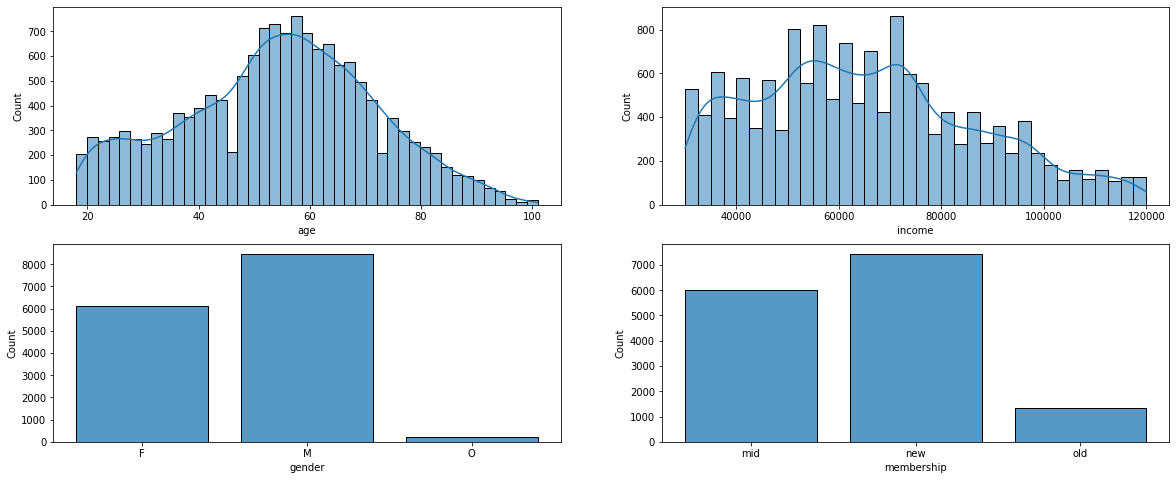

In [24]:
# histogram plots for each variable
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 8))
sns.histplot(data=df, x="age", kde=True, ax=ax1)
sns.histplot(data=df, x="income",  kde=True, ax=ax2)
sns.histplot(data=df, x="gender", shrink=0.8, ax=ax3)
sns.histplot(data=df, x="membership", shrink=0.8, ax=ax4)

<AxesSubplot:xlabel='age', ylabel='income'>

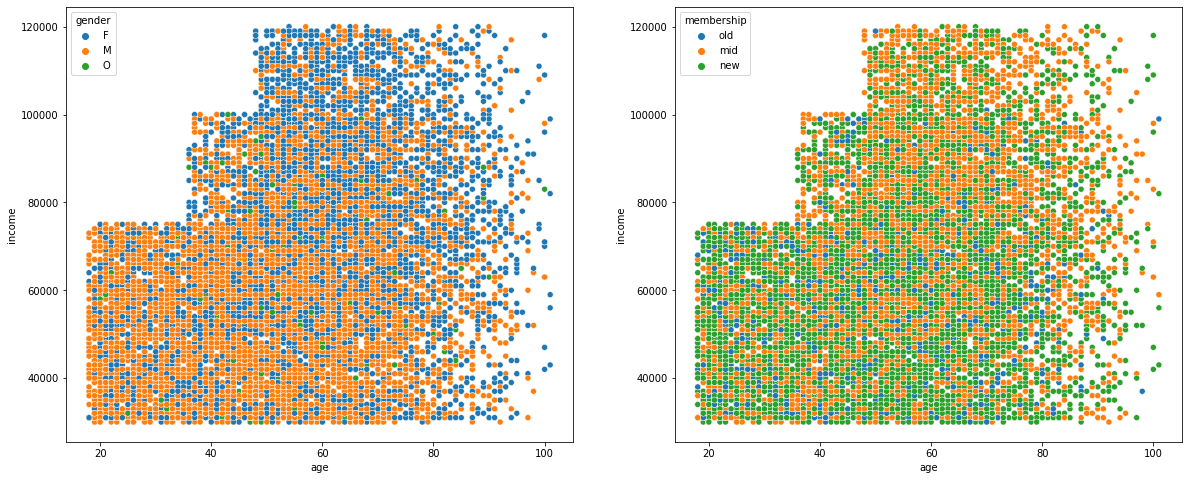

In [25]:
# bivariate scatter plots

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 8))
sns.scatterplot(data=df, x="age", y="income", hue="gender", ax=ax1)
sns.scatterplot(data=df, x="age", y="income", hue="membership", hue_order=["old", "mid", "new"], ax=ax2)

<AxesSubplot:xlabel='age', ylabel='income'>

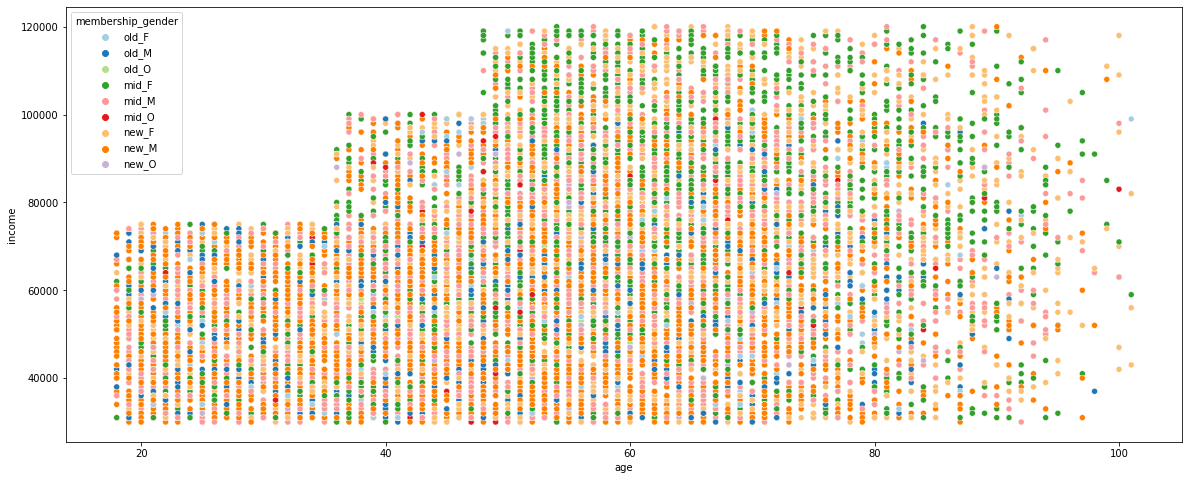

In [26]:
df["membership_gender"] = df["membership"] + "_" + df["gender"]
hue_order = [ 'old_F',  'old_M',  'old_O', 'mid_F',  'mid_M',  'mid_O', 'new_F',  'new_M',  'new_O']

fig, ax = plt.subplots(figsize=(20, 8))
sns.scatterplot(data=df, x="age", y="income", hue="membership_gender", hue_order=hue_order, palette="Paired", ax=ax)

<AxesSubplot:xlabel='income', ylabel='Density'>

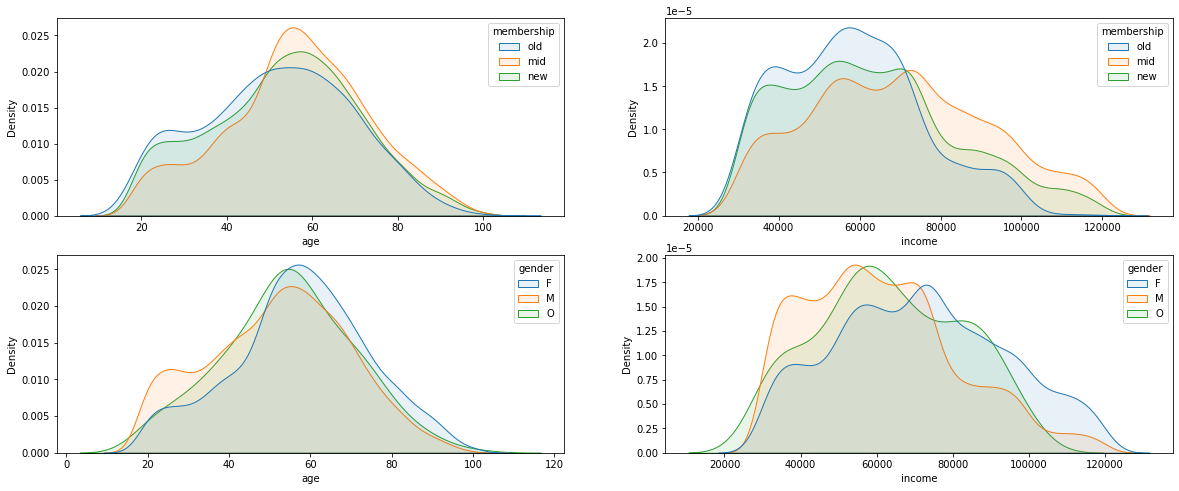

In [27]:
# univariate density plots

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 8))
sns.kdeplot(data=df, x="age", hue="membership", hue_order=["old", "mid", "new"], common_norm=False, fill=True, alpha=0.1, ax=ax1)
sns.kdeplot(data=df, x="income", hue="membership", hue_order=["old", "mid", "new"], common_norm=False, fill=True, alpha=0.1, ax=ax2)
sns.kdeplot(data=df, x="age", hue="gender", common_norm=False, fill=True, alpha=0.1, ax=ax3)
sns.kdeplot(data=df, x="income", hue="gender", common_norm=False, fill=True, alpha=0.1, ax=ax4)

/home/jovyan/venv/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


<AxesSubplot:xlabel='age', ylabel='income'>

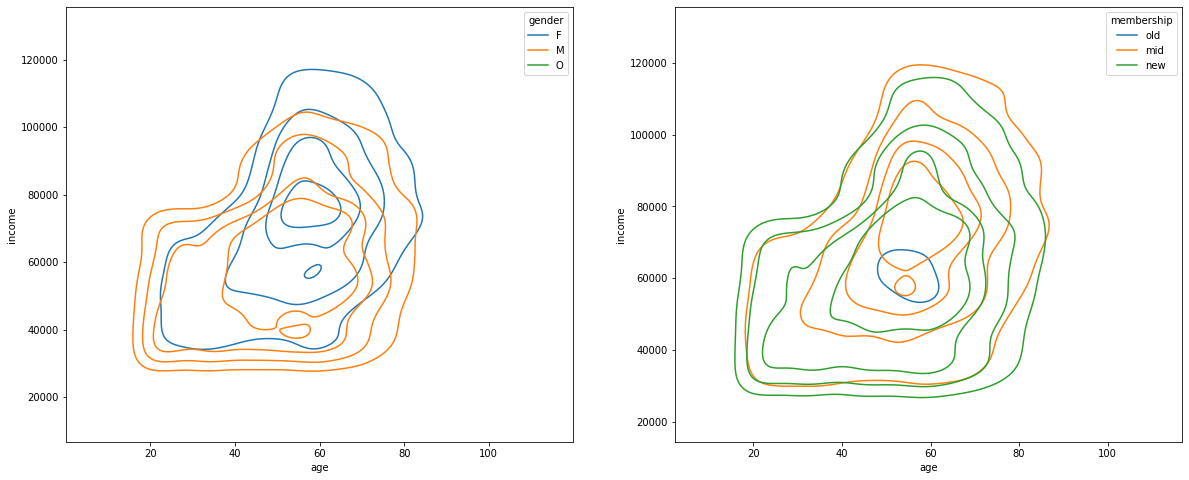

In [28]:
# bivariate density plots

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 8))
sns.kdeplot(data=df, x="age", y="income", hue="gender", levels=5, thresh=0.2, ax=ax1)
sns.kdeplot(data=df, x="age", y="income", hue="membership",  hue_order=["old", "mid", "new"], levels=5, thresh=0.2, ax=ax2)

<AxesSubplot:xlabel='gender', ylabel='income'>

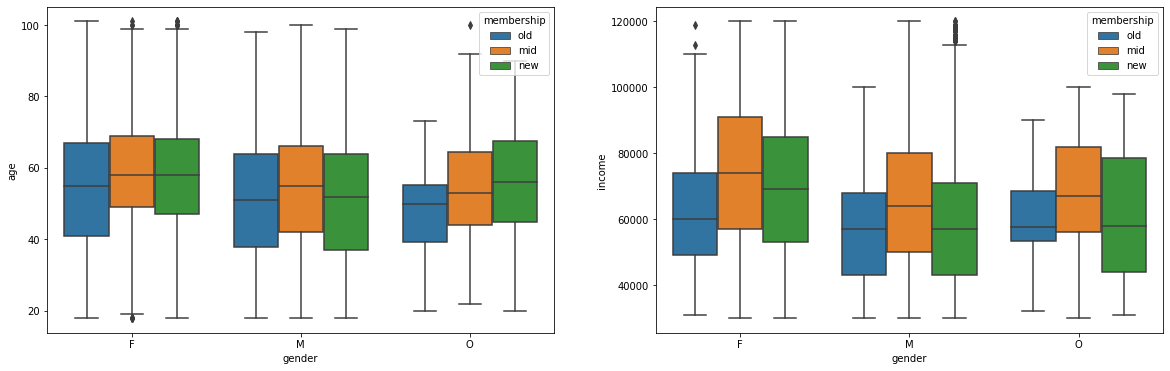

In [29]:
# boxplots

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(data=df, x="gender", y="age", hue="membership", hue_order=["old", "mid", "new"], ax=ax1)
sns.boxplot(data=df, x="gender", y="income", hue="membership", hue_order=["old", "mid", "new"], ax=ax2)

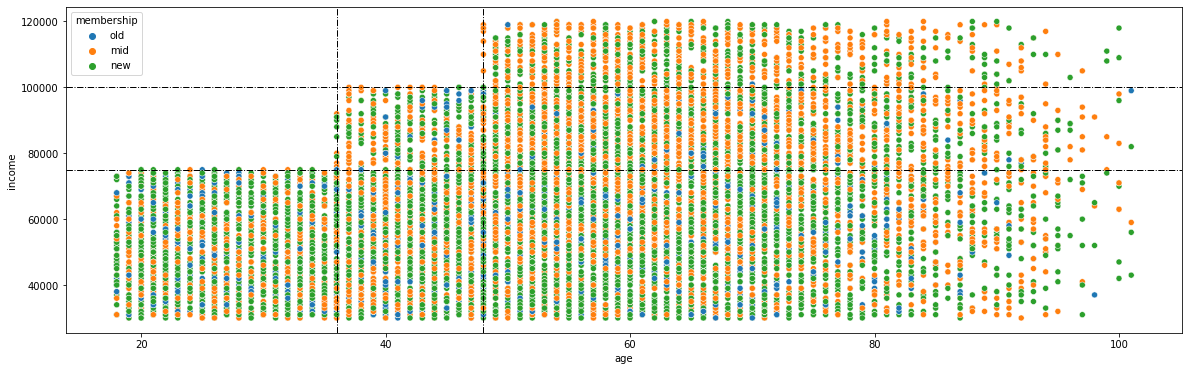

In [30]:
# observation on age - income scatter plot

fig, ax = plt.subplots(figsize=(20,6))
sns.scatterplot(data=df, x="age", y="income", hue="membership",  hue_order=["old", "mid", "new"])
plt.axvline(x=36, color='k', linewidth=1, linestyle="-.")
plt.axvline(x=48, color='k', linewidth=1, linestyle="-.")
plt.axhline(y=75000, color='k', linewidth=1, linestyle="-.")
plt.axhline(y=100000, color='k', linewidth=1, linestyle="-.")

#### Numerical Analysis

In [31]:
round(((1 - (len(df) / len(profile))) * 100), 3)

12.794

In [32]:
# age - income stats
df[["age", "income"]].describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [33]:
# age - income stats respect to gender
df[["gender", "age", "income"]].groupby("gender").agg(["count", "min", "max", "median", "mean", "std"])

age                                       income                     \
       count min  max median       mean        std  count      min       max   
gender                                                                         
F       6129  18  101   58.0  57.544950  16.883315   6129  30000.0  120000.0   
M       8484  18  100   53.0  52.116690  17.413894   8484  30000.0  120000.0   
O        212  20  100   55.0  54.400943  16.244710    212  30000.0  100000.0   

                                             
         median          mean           std  
gender                                       
F       71000.0  71306.412139  22338.353773  
M       59000.0  61194.601603  20069.517615  
O       62000.0  63287.735849  18938.594726

In [34]:
# age - income stats respect to membership
df[["membership", "age", "income"]].groupby("membership").agg(["count", "min", "max", "median", "mean", "std"])

age                                       income           \
           count min  max median       mean        std  count      min   
membership                                                               
mid         6018  18  101   57.0  56.204055  16.887585   6018  30000.0   
new         7452  18  101   54.0  53.446457  17.609369   7452  30000.0   
old         1355  18  101   52.0  51.560886  17.527310   1355  30000.0   

                                                           
                 max   median          mean           std  
membership                                                 
mid         120000.0  70000.0  69974.410103  22172.544920  
new         120000.0  61000.0  62987.922705  21094.863778  
old         119000.0  57000.0  58403.690037  17313.133597

In [35]:
# age - income stats respect to gender - membership
df[["gender", "membership", "age", "income"]].groupby(["gender", "membership"]).agg(["count", "min", "max", "median", "mean", "std"])

age                                       income           \
                  count min  max median       mean        std  count      min   
gender membership                                                               
F      mid         2935  18  101   58.0  58.362862  16.441221   2935  30000.0   
       new         2876  18  101   58.0  57.116829  17.141851   2876  30000.0   
       old          318  18  101   55.0  53.867925  17.944398    318  31000.0   
M      mid         2996  18  100   55.0  54.133845  17.096030   2996  30000.0   
       new         4465  18   99   52.0  51.039194  17.515713   4465  30000.0   
       old         1023  18   98   51.0  50.912023  17.378037   1023  30000.0   
O      mid           87  22  100   53.0  54.666667  15.553857     87  30000.0   
       new          111  20   90   56.0  55.180180  16.834055    111  31000.0   
       old           14  20   73   50.0  46.571429  14.600918     14  32000.0   

                                                                  
                        max   median          mean           std  
gender membership                                                 
F      mid         120000.0  74000.0  74190.800681  22431.924978  
       new         120000.0  69000.0  69326.147427  22128.683520  
       old         119000.0  60000.0  62594.339623  18952.261945  
M      mid         120000.0  64000.0  65919.893191  21237.937945  
       new         120000.0  57000.0  58968.868981  19388.805480  
       old         100000.0  57000.0  57070.381232  16593.061188  
O      mid         100000.0  67000.0  67356.321839  18301.084611  
       new          98000.0  58000.0  60432.432432  19376.941133  
       old          90000.0  57500.0  60642.857143  15519.749913

##### Comments

- NULL profiles forms about %13 of profiles. The percentage is not soo small to neglect, not too big not to be able to impute.
- Female population has relatively better income.
- Female population age average is slightly higher than the others.
- Old and new members are inclined to be male.
- There are four magical numbers seen on age-income scatter plot: Spikes @age=36 and @age=48, also @income=75000 and @income=100000

##### Actions

- Bucketing age-income:
    - Due to the fact that Tree-Based ML Algorithms are going to be implemented, obvious separation on age and income will ease the algorithm's job.
    - Also, this will make the imputation easier for null profiles. <br><br>

- Imputing age-income-gender of NULL profiles:
    - According to membership value, age, income bucket and gender of a NULL profile will be randomly selected regarding prior probability.
    - Seed value should be used for imputation to get the same data. This process will keep the distribution of variables similar to not NULL profiles. <br><br>

- _is_null_profile_ column differentiates whether a profile was NULL or not after imputation. This will be kept in profile dataset as _was_null_profile_

- Conversion into categorical variables needs encoding, which will be done in feature engineering stage.

### Preprocessing Profile

#### Bucketing Age and Income Features

In [36]:
def bucket_income(income):
    '''
    Returns the associated income bucket according to given income.

    Parameters
    ----------
        income (float): A floating number that indicates the customer's income.

    Returns
    ----------
        income_bucket (str): A string that indicates the associated income in six categories.
                             Categories -> 30k_40k, 40k_50k, 50k_60k, 60k_75k, 75k_100k, 100k_120k
                                             
    '''
    
    if income < 40000:
        income_bucket = "30k_40k"
    elif income < 50000:
        income_bucket = "40k_50k"
    elif income < 60000:
        income_bucket = "50k_60k"
    elif income < 75000:
        income_bucket = "60k_75k"
    elif income < 100000:
        income_bucket = "75k_100k"
    else:
        income_bucket = "100k_120k"
        
    return income_bucket

def bucket_age(age):
    '''
    Returns the associated age bucket according to given age.

    Parameters
    ----------
        age (float): A floating number that indicates the customer's income.

    Returns
    ----------
        age_bucket (str): A string that indicates the associated age in twelve categories.
                          Categories -> 18_23, 24_29, 30_35, 36_41, 42_47, 48_53, 54_59, 60_65, 66_71, 72_77, 78_83, 84_101
    '''
    
    if age < 24:
        age_bucket = "18_23"
    elif age < 30:
        age_bucket = "24_29"
    elif age < 36:
        age_bucket = "30_35"
    elif age < 42:
        age_bucket = "36_41"
    elif age < 48:
        age_bucket = "42_47"
    elif age < 54:
        age_bucket = "48_53"
    elif age < 60:
        age_bucket = "53_59"
    elif age < 66:
        age_bucket = "60_65"
    elif age < 72:
        age_bucket = "66_71"
    elif age < 78:
        age_bucket = "72_77"
    elif age < 84:
        age_bucket = "78_83"
    else:
        age_bucket = "84_101"
        
    return age_bucket

In [37]:
df["age_bucket"] = df["age"].apply(lambda x: bucket_age(x))
df["income_bucket"] = df["income"].apply(lambda x: bucket_income(x))
df.head()

,became_member_on,age,gender,income,bmo_year_month,is_null_profile,membership,membership_gender,age_bucket,income_bucket
customer_id,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,20170715,55,F,112000.0,201707,0,mid,mid_F,53_59,100k_120k
78afa995795e4d85b5d9ceeca43f5fef,20170509,75,F,100000.0,201705,0,mid,mid_F,72_77,100k_120k
e2127556f4f64592b11af22de27a7932,20180426,68,M,70000.0,201804,0,new,new_M,66_71,60k_75k
389bc3fa690240e798340f5a15918d5c,20180209,65,M,53000.0,201802,0,new,new_M,60_65,50k_60k
2eeac8d8feae4a8cad5a6af0499a211d,20171111,58,M,51000.0,201711,0,new,new_M,53_59,50k_60k


In [38]:
# Store the values

df_normal = df[["membership", "gender", "age_bucket", "income_bucket"]].reset_index()
df_normal["was_null_profile"] = 0

df_normal.head()

,customer_id,membership,gender,age_bucket,income_bucket,was_null_profile
0,0610b486422d4921ae7d2bf64640c50b,mid,F,53_59,100k_120k,0
1,78afa995795e4d85b5d9ceeca43f5fef,mid,F,72_77,100k_120k,0
2,e2127556f4f64592b11af22de27a7932,new,M,66_71,60k_75k,0
3,389bc3fa690240e798340f5a15918d5c,new,M,60_65,50k_60k,0
4,2eeac8d8feae4a8cad5a6af0499a211d,new,M,53_59,50k_60k,0


In [39]:
df_normal.shape

(14825, 6)

#### Imputation of NULL profiles

Imputation on NULL profile's age_bucket, gender and income_bucket will be based on the prior data.
- A table which shows the prior probabilities for given membership will be created for each variable.
- This table has three columns: membership level, variable categories, seed number and prior probabilities.
- According to that table, a random selection will be performed for NULL profile.

##### Prior Probability Lookup Tables

In [40]:
def create_prob_table(df, bucket_name):
    '''
    Returns the probability table of the given bucket name based on membership column.

            Parameters:
                    df (pd.DataFrame): A dataframe including NOT NULL values of membership column and categorical variable.
                    bucket_name (string): A string that indicates the categorical variable name.

            Returns:
                    prob_table (pd.DataFrame): A dataframe including membership, categorical variable and probability.
                                             
    '''
    # calculate probabilities
    p = df[["membership", bucket_name]].groupby(["membership", bucket_name]).size().rename("count").reset_index()
    p = p.merge(p.groupby("membership").sum().reset_index(), on="membership", how="left")
    p["prob"] = p["count_x"] / p["count_y"]
    
    # construct the table
    prob_table = p.pivot_table(index=bucket_name, columns="membership", values="prob", aggfunc="mean", fill_value=0)
    prob_table = pd.DataFrame(index=prob_table.index, columns=["mid", "new", "old"], data=prob_table.values).reset_index()
                           
    return prob_table

In [41]:
age_prob_table = create_prob_table(df_normal, "age_bucket")
age_prob_table.head()

,age_bucket,mid,new,old
0,18_23,0.038385,0.055690,0.067159
1,24_29,0.043702,0.063205,0.076015
2,30_35,0.041874,0.061326,0.067159
3,36_41,0.071785,0.077160,0.081181
4,42_47,0.078598,0.092458,0.108487


This table indicates probability of being in the age_bucket for a given membership category. For instance, membership='mid' then probability of being in age_bucket='18_23' is 0.038385. Similarly, tables for **income_bucket** and **gender** is created.

In [42]:
income_prob_table = create_prob_table(df_normal, "income_bucket")
income_prob_table.head()

,income_bucket,mid,new,old
0,100k_120k,0.104852,0.060923,0.005904
1,30k_40k,0.097707,0.151100,0.166790
2,40k_50k,0.093719,0.142244,0.160148
3,50k_60k,0.164673,0.184380,0.218450
4,60k_75k,0.238784,0.260735,0.298893


In [43]:
gender_prob_table = create_prob_table(df_normal, "gender")
gender_prob_table.head()

,gender,mid,new,old
0,F,0.487704,0.385937,0.234686
1,M,0.497840,0.599168,0.754982
2,O,0.014457,0.014895,0.010332


##### Perform Imputation

In [44]:
df_null = profile_[profile_["is_null_profile"] == 1].set_index("customer_id").copy()
df_null.head()

,became_member_on,age,gender,income,bmo_year_month,is_null_profile,membership
customer_id,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,20170212,118,None,NaN,201702,1,mid
38fe809add3b4fcf9315a9694bb96ff5,20180712,118,None,NaN,201807,1,new
a03223e636434f42ac4c3df47e8bac43,20170804,118,None,NaN,201708,1,new
8ec6ce2a7e7949b1bf142def7d0e0586,20170925,118,None,NaN,201709,1,new
68617ca6246f4fbc85e91a2a49552598,20171002,118,None,NaN,201710,1,new


In [45]:
# random seed for each customer to get the same random buckets
# this is made in order to provide assigning the same bucket to customers that are in the same membership category
np.random.seed(13)
df_null["seed"] = np.random.randint(0, 100000, len(df_null))
df_null.head()

,became_member_on,age,gender,income,bmo_year_month,is_null_profile,membership,seed
customer_id,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,20170212,118,None,NaN,201702,1,mid,98642
38fe809add3b4fcf9315a9694bb96ff5,20180712,118,None,NaN,201807,1,new,47280
a03223e636434f42ac4c3df47e8bac43,20170804,118,None,NaN,201708,1,new,98378
8ec6ce2a7e7949b1bf142def7d0e0586,20170925,118,None,NaN,201709,1,new,33634
68617ca6246f4fbc85e91a2a49552598,20171002,118,None,NaN,201710,1,new,87796


In [46]:
def assign_bucket(prob_table, bucket_name, seed, category):
    '''
    Returns the bucket value of given bucket_name based on given probability table.

    Parameters
    ----------
        prob_table (pd.DataFrame): A dataframe including prior bucket probabilities respect to membership category.
        bucket_name (string): A string that indicates the categorical variable name.
        seed (int): An integer for randomness of each customer.

    Returns
    ----------
        category (string): A string to impute the related bucket.
                                             
    '''
    
    choices = prob_table[bucket_name].tolist()
    probs = prob_table[category].tolist()
    
    np.random.seed(seed)
    category = np.random.choice(choices, p=probs)
    
    return category 

In [47]:
df_null["age_bucket"] = df_null.apply(lambda x:  assign_bucket(age_prob_table, "age_bucket",  x["seed"], x["membership"]), axis=1)
df_null["income_bucket"] = df_null.apply(lambda x:  assign_bucket(income_prob_table, "income_bucket",  x["seed"], x["membership"]), axis=1)
df_null["gender"] = df_null.apply(lambda x:  assign_bucket(gender_prob_table, "gender",  x["seed"], x["membership"]), axis=1)
df_null.head()

,became_member_on,age,gender,income,bmo_year_month,is_null_profile,membership,seed,age_bucket,income_bucket
customer_id,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,20170212,118,M,NaN,201702,1,mid,98642,60_65,60k_75k
38fe809add3b4fcf9315a9694bb96ff5,20180712,118,F,NaN,201807,1,new,47280,30_35,30k_40k
a03223e636434f42ac4c3df47e8bac43,20170804,118,M,NaN,201708,1,new,98378,78_83,75k_100k
8ec6ce2a7e7949b1bf142def7d0e0586,20170925,118,M,NaN,201709,1,new,33634,60_65,60k_75k
68617ca6246f4fbc85e91a2a49552598,20171002,118,F,NaN,201710,1,new,87796,36_41,40k_50k


In [48]:
df_null = df_null[["membership", "gender", "age_bucket", "income_bucket"]].reset_index()
df_null["was_null_profile"] = 1
df_null.head()

,customer_id,membership,gender,age_bucket,income_bucket,was_null_profile
0,68be06ca386d4c31939f3a4f0e3dd783,mid,M,60_65,60k_75k,1
1,38fe809add3b4fcf9315a9694bb96ff5,new,F,30_35,30k_40k,1
2,a03223e636434f42ac4c3df47e8bac43,new,M,78_83,75k_100k,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,new,M,60_65,60k_75k,1
4,68617ca6246f4fbc85e91a2a49552598,new,F,36_41,40k_50k,1


##### Resulting Distributions

In [49]:
# age
age_normal = df_normal["age_bucket"].value_counts() / len(df_normal)
age_null = df_null["age_bucket"].value_counts() / len(df_null)

d = pd.concat([age_normal, age_null], axis=1, keys=["normal", "null"]).sort_index()
d

,normal,null
18_23,0.049713,0.048736
24_29,0.056459,0.047356
30_35,0.053963,0.057931
36_41,0.075346,0.070805
42_47,0.088297,0.086897
48_53,0.133491,0.136092
53_59,0.146442,0.140690
60_65,0.127420,0.124138
66_71,0.106847,0.115862
72_77,0.070691,0.069885


In [50]:
# income
income_normal = df_normal["income_bucket"].value_counts() / len(df_normal)
income_null = df_null["income_bucket"].value_counts() / len(df_null)

d = pd.concat([income_normal, income_null], axis=1, keys=["normal", "null"])
d = d.loc[sorted(d.index)[1:] + [sorted(d.index)[0]]]

d

,normal,null
30k_40k,0.130860,0.125977
40k_50k,0.124182,0.115402
50k_60k,0.179494,0.183908
60k_75k,0.255312,0.239080
75k_100k,0.236425,0.257471
100k_120k,0.073727,0.078161


In [51]:
# gender
gender_normal = df_normal["gender"].value_counts() / len(df_normal)
gender_null = df_null["gender"].value_counts() / len(df_null)

d = pd.concat([gender_normal, gender_null], axis=1, keys=["normal", "null"])

d

,normal,null
M,0.572277,0.559080
F,0.413423,0.425747
O,0.014300,0.015172


There are no significant differences on the distributions. Imputation has been performed.  

##### Construct Profile Table

In [52]:
df_normal.head()

,customer_id,membership,gender,age_bucket,income_bucket,was_null_profile
0,0610b486422d4921ae7d2bf64640c50b,mid,F,53_59,100k_120k,0
1,78afa995795e4d85b5d9ceeca43f5fef,mid,F,72_77,100k_120k,0
2,e2127556f4f64592b11af22de27a7932,new,M,66_71,60k_75k,0
3,389bc3fa690240e798340f5a15918d5c,new,M,60_65,50k_60k,0
4,2eeac8d8feae4a8cad5a6af0499a211d,new,M,53_59,50k_60k,0


In [53]:
df_null.head()

,customer_id,membership,gender,age_bucket,income_bucket,was_null_profile
0,68be06ca386d4c31939f3a4f0e3dd783,mid,M,60_65,60k_75k,1
1,38fe809add3b4fcf9315a9694bb96ff5,new,F,30_35,30k_40k,1
2,a03223e636434f42ac4c3df47e8bac43,new,M,78_83,75k_100k,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,new,M,60_65,60k_75k,1
4,68617ca6246f4fbc85e91a2a49552598,new,F,36_41,40k_50k,1


In [54]:
profile_ = pd.concat([df_normal, df_null], ignore_index=True)
profile_.head()

,customer_id,membership,gender,age_bucket,income_bucket,was_null_profile
0,0610b486422d4921ae7d2bf64640c50b,mid,F,53_59,100k_120k,0
1,78afa995795e4d85b5d9ceeca43f5fef,mid,F,72_77,100k_120k,0
2,e2127556f4f64592b11af22de27a7932,new,M,66_71,60k_75k,0
3,389bc3fa690240e798340f5a15918d5c,new,M,60_65,50k_60k,0
4,2eeac8d8feae4a8cad5a6af0499a211d,new,M,53_59,50k_60k,0


In [55]:
profile_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       17000 non-null  object
 1   membership        17000 non-null  object
 2   gender            17000 non-null  object
 3   age_bucket        17000 non-null  object
 4   income_bucket     17000 non-null  object
 5   was_null_profile  17000 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 797.0+ KB


# Data Exploration - Transcript: Transaction & Offer

In [56]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [57]:
transcript_ = transcript.rename(columns={"person":"customer_id"})
transcript_.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [58]:
#Check the value keys
transcript_["keys"] = transcript_["value"].apply(lambda x: list(x.keys())).astype(str)
transcript_[["event", "keys"]].groupby(["event", "keys"]).size().rename("count").reset_index()

,event,keys,count
0,offer completed,"['offer_id', 'reward']",33579
1,offer received,['offer id'],76277
2,offer viewed,['offer id'],57725
3,transaction,['amount'],138953


- There are four event types. _offer_id_ stands for the related offer in portfolio table. This data set can be splitted into two: **Offer** & **Transaction**

In [59]:
#Check reward values in case of mismatch with portfolio table
offer_completed = transcript_.loc[transcript_["event"] == "offer completed", "value"].apply(pd.Series)
offer_completed = offer_completed.drop_duplicates()
offer_completed

,offer_id,reward
12658,2906b810c7d4411798c6938adc9daaa5,2
12672,fafdcd668e3743c1bb461111dcafc2a4,2
12679,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,4d5c57ea9a6940dd891ad53e9dbe8da0,10
12721,2298d6c36e964ae4a3e7e9706d1fb8c2,3
12744,f19421c1d4aa40978ebb69ca19b0e20d,5
14634,0b1e1539f2cc45b7b9fa7c272da2e1d7,5


In [60]:
offer_completed.merge(portfolio_, on="offer_id", how="left")

,offer_id,reward_x,offer_type,difficulty,duration,reward_y,web,mobile,social
0,2906b810c7d4411798c6938adc9daaa5,2,discount,10,7,2,1,1,0
1,fafdcd668e3743c1bb461111dcafc2a4,2,discount,10,10,2,1,1,1
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,bogo,5,7,5,1,1,0
3,ae264e3637204a6fb9bb56bc8210ddfd,10,bogo,10,7,10,0,1,1
4,4d5c57ea9a6940dd891ad53e9dbe8da0,10,bogo,10,5,10,1,1,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,discount,7,7,3,1,1,1
6,f19421c1d4aa40978ebb69ca19b0e20d,5,bogo,5,5,5,1,1,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,discount,20,10,5,1,0,0


Reward values are the same as in the portfolio. Therefore, reward information can be removed.

## Transaction

In [61]:
mask = transcript_["event"] == "transaction"
transaction = transcript_[mask].reset_index(drop=True)
transaction.head()

,customer_id,event,value,time,keys
0,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,['amount']
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,['amount']
2,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,['amount']
3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,['amount']
4,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,['amount']


In [62]:
# extract value column
val_col = transaction["value"].apply(pd.Series)
val_col.head()

,amount
0,0.83
1,34.56
2,13.23
3,19.51
4,18.97


In [63]:
# keep values in different dataframe
transaction_ = transaction.join(val_col)
transaction_ = transaction_.drop(columns=["event", "value", "keys"], axis=1)
transaction_ = transaction_.sort_values(["customer_id", "time"]).reset_index(drop=True)
transaction_["time"] = transaction_["time"].astype(int)

transaction_.head()

,customer_id,time,amount
0,0009655768c64bdeb2e877511632db8f,228,22.16
1,0009655768c64bdeb2e877511632db8f,414,8.57
2,0009655768c64bdeb2e877511632db8f,528,14.11
3,0009655768c64bdeb2e877511632db8f,552,13.56
4,0009655768c64bdeb2e877511632db8f,576,10.27


### Exploration

In [64]:
# check duplicated values
transaction_.duplicated(["customer_id", "time"]).sum()

0

There are no duplicated values. It means that payments are aggregated on time.

#### Profile

In [65]:
transaction_["customer_id"].nunique()

16578

There are 422 customers, which they have demographic info, but no transactional info.

#### Time

In [66]:
transaction_["time"].nunique()

120

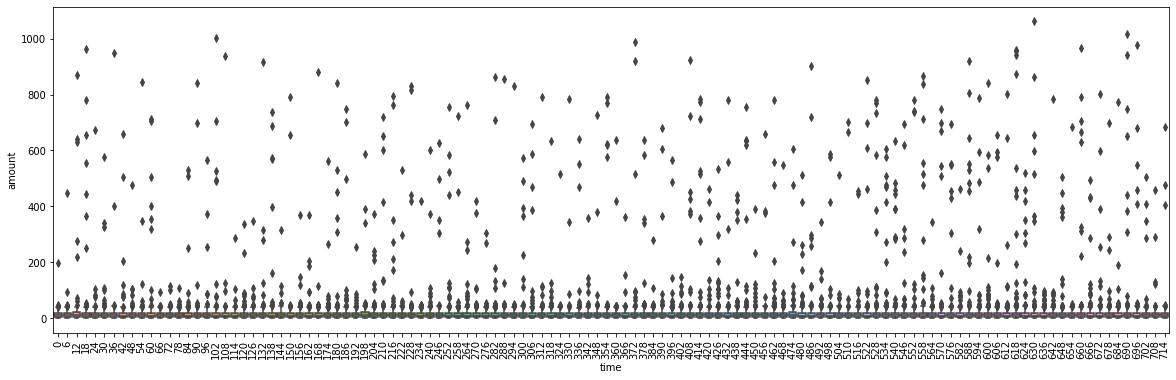

In [67]:
# boxplot of time - amount

fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=transaction_, x="time", y="amount", ax=ax)
plt.xticks(rotation=90)
ax.margins(x=0)

It is hard to read this chart. Plot the same graph, taking log of amount values. 

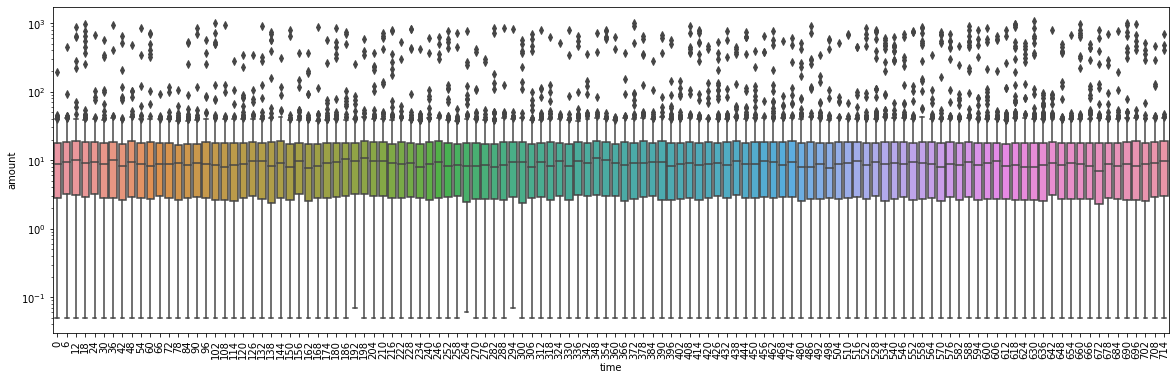

In [68]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=transaction_, x="time", y="amount", ax=ax)
plt.xticks(rotation=90)
ax.margins(x=0)
ax.set_yscale("log")

There are a lot of marginal amount values, and they cannot be accepted as outliers due to the number of these samples. <br>
Also the median value of amount is around 10, which is a good payment value to complete the most of the offers.

### Transactional Featues

In [69]:
transaction_["total_trans_amount"] = transaction_.groupby("customer_id")["amount"].apply(lambda x: x.cumsum())
transaction_["total_trans_count"] = transaction_.groupby("customer_id")["amount"].cumcount().fillna(0) + 1
transaction_["avg_trans_amount"] = (transaction_["total_trans_amount"] / transaction_["total_trans_count"]).round(3)
transaction_.head()

,customer_id,time,amount,total_trans_amount,total_trans_count,avg_trans_amount
0,0009655768c64bdeb2e877511632db8f,228,22.16,22.16,1,22.160
1,0009655768c64bdeb2e877511632db8f,414,8.57,30.73,2,15.365
2,0009655768c64bdeb2e877511632db8f,528,14.11,44.84,3,14.947
3,0009655768c64bdeb2e877511632db8f,552,13.56,58.40,4,14.600
4,0009655768c64bdeb2e877511632db8f,576,10.27,68.67,5,13.734


## Offer

In [204]:
mask = transcript_["event"] == "transaction"
offer = transcript_[~mask].reset_index(drop=True)
offer.head()

,customer_id,event,value,time,keys
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,['offer id']
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,['offer id']
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,['offer id']
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,['offer id']
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,['offer id']


In [205]:
offer["event"].value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

Offer table will be the base table for this project. For each customer and for each offer sent in different time, there will be a dataset sample. <br>
Prediction will be made after offer is received. Therefore, there are three valid cases as abovementioned.
There are 76277 offer received sample. Therefore, there will be 76277 samples on the base dataset.

In [206]:
# extract values
val_col = offer["value"].apply(pd.Series).fillna("")
val_col["offer_id"] = val_col["offer_id"] + val_col["offer id"]
val_col = val_col.drop(columns=["offer id"], axis=1)

offer = offer.join(val_col)

### Offer Chains

In [207]:
offer_received = offer[offer["event"] == "offer received"].copy()
offer_received[offer_received.duplicated("customer_id")].sort_values(["customer_id", "offer_id"])

,customer_id,event,value,time,keys,offer_id,reward
139458,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,['offer id'],2906b810c7d4411798c6938adc9daaa5,
58310,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,['offer id'],3f207df678b143eea3cee63160fa8bed,
83625,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,['offer id'],f19421c1d4aa40978ebb69ca19b0e20d,
112507,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,['offer id'],fafdcd668e3743c1bb461111dcafc2a4,
139938,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576,['offer id'],f19421c1d4aa40978ebb69ca19b0e20d,
...,...,...,...,...,...,...,...
28651,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},168,['offer id'],0b1e1539f2cc45b7b9fa7c272da2e1d7,
56919,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},336,['offer id'],2906b810c7d4411798c6938adc9daaa5,
82254,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408,['offer id'],2906b810c7d4411798c6938adc9daaa5,
138074,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,['offer id'],2906b810c7d4411798c6938adc9daaa5,


Offer chains are the offer history of a customer for each offer type. <br>
A customer may receive the same offer in different times, which is seen on the tail of dataframe above. <br>
For each offer, an offer chain will be created to explore, analyse and clean the data.

#### Creation of Offer Chains
- Events will be mapped into chars -> A: Offer Received, B: Offer Viewed, C: Offer Completed
- Time values will be joined into these mapped events.
- These strings are going to be joined in the way of creating a sequence:
    - Example: For Customer X and Offer Y -> 336A-408B-416C-422A-434A: 
        - At time = 336 - Offer Received
        - At time = 408 - Offer Viewed
        - At time = 416 - Offer Completed
        - At time = 422 - Offer Received
        - At time = 434 - Offer Received

In [208]:
d = {"offer received": "A", 
     "offer viewed": "B", 
     "offer completed": "C"}

offer["event_encoded"] = offer["event"].map(d)
offer["time_event"] = offer["time"].astype(str).str.zfill(3) + offer["event_encoded"]

offer_ = offer[["customer_id", "offer_id", "time_event"]]
offer_.head()

,customer_id,offer_id,time_event
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,000A
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,000A
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,000A
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,000A
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,000A


In [209]:
offer_chains = offer_.sort_values(["customer_id", "offer_id", "time_event"]).groupby(["customer_id", "offer_id"]).agg("-".join).reset_index()
offer_chains.head()

,customer_id,offer_id,time_event
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576A-576C
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336A-372B
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168A-192B
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414C-456B
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528C-540B


For the same string length for time, the field is filled by 0s. Now, an offer history can easily be seen. Check the number of samples for convenience.

In [210]:
print("Number of samples in Offer Data Set: ", offer.shape[0])
print("Number of samples in Offer Chains: ", offer_chains["time_event"].apply(lambda x: len(x.split("-"))).sum())

Number of samples in Offer Data Set:  167581
Number of samples in Offer Chains:  167581


#### Validation of Offer Chains

In [211]:
offer_chains["sequence"] = offer_chains["time_event"].apply(lambda x: "".join([ch for ch in x if ch.isalpha()]))
offer_chains.head()

,customer_id,offer_id,time_event,sequence
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576A-576C,AC
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336A-372B,AB
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168A-192B,AB
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414C-456B,ACB
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528C-540B,ACB


In [212]:
offer_chains["sequence"].nunique()

210

In [213]:
offer_chains["sequence"].value_counts().sort_index()

A            8540
AA            994
AAA            80
AAAA            3
AAAAC           1
             ... 
ACBACBA         1
ACBACBAB        1
ACBACBABC       5
ACBACBAC        2
ACBACBACB       2
Name: sequence, Length: 210, dtype: int64

Note that every sequence starts with A. Therefore, only the pairs will be examined. The  table below showing the chain validity.

| Subsequence | Validity                                                                                         | Action                                                   |
|-------------|--------------------------------------------------------------------------------------------------|----------------------------------------------------------|
| A           | Yes. Offer is received but neither viewed nor completed.                                         |                                                          |
| AA          | Yes. Offer is received but neither viewed nor completed. Then, the same offer is received again. |                                                          |
| AB          | Yes. Offer is received and viewed, but not completed.                                            |                                                          |
| AC          | No.  Offer is received, but completed before viewed.                                             | Assume that offer is viewed at the time it is completed. |
| BA          | Yes. Offer is viewed. Then the same offer is received again.                                     |                                                          |
| BB          | No.  The same offer is viewed twice.                                                             | Remove the latter incidence from the chain.              |
| BC          | Yes. Offer is viewed and completed.                                                              |                                                          |
| CA          | Yes. Offer is completed. Then, the same offer is received again.                                 |                                                          |
| CB          | No.  Offer is completed. Then, it is viewed before received.                                     | Remove the latter incidence from the chain.              |
| CC          | No.  Offer is completed. Then, the same offer is completed again.                                | Remove the latter incidence from the chain.              |

As an example of a sequence: ABACCBABBCB - There are 3 offer received sample.
- Insert B into AC subsequences: AB(ABC)CBABBCB
- Remove B from BB subsequences: AB(ABC)CBAB-CB
- Remove B from CB subsequences: AB(ABC)C-AB-C-
- Remove C from CC subsequences: AB(ABC)--AB-C-
- Final Sequence: ABABCABC   
- Decompose the chain as: AB -- ABC -- ABC -> 3 samples in the base table (2 for Class 0, 1 for Class 1)

In [214]:
def check_sequence_validity(sequence):
    '''
    Returns the partially fixed sequence by insertion.
    
    Parameters
    ----------
        sequence (string): A string that indicates the sequence of the incidences.
        
    Returns
    ----------
        valid_flag (bool): A boolean variable that indicates if the sequence is valid or not.
                           This is made respect to the rule set.
                                             
    '''
    # check length
    if len(sequence) == 1:
        if sequence == "A":
            return 1
        else:
            return 0
    else:
        l1, l2 = sequence[:-1], sequence[1:]
        check_list = set([l1[i] + l2[i] for i in range(len(l1))])
        
        # invalid pairs
        for pair in check_list:
            if pair in ["AC", "BB", "CB", "CC"]:
                return 0
        
    return 1

In [215]:
offer_chains["valid"]  = offer_chains["sequence"].apply(lambda x: check_sequence_validity(x))
offer_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576A-576C,AC,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336A-372B,AB,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168A-192B,AB,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414C-456B,ACB,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528C-540B,ACB,0


##### Valid Chains

In [216]:
mask = offer_chains["valid"] == 1
valid_chains = offer_chains[mask].reset_index(drop=True)

valid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336A-372B,AB,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168A-192B,AB,1
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168A-216B-576A-630B,ABAB,1
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408A-432B-576C,ABC,1
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168A-186B-252C,ABC,1


In [217]:
valid_chains.shape

(53755, 5)

##### Invalid Chains

In [218]:
mask = offer_chains["valid"] == 0
invalid_chains = offer_chains[mask].reset_index(drop=True)

invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576A-576C,AC,0
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414C-456B,ACB,0
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528C-540B,ACB,0
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,000A-012B-054C-336A-510C,ABCAC,0
4,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,504A-696C,AC,0


In [219]:
invalid_chains.shape

(9533, 5)

#### Fix Invalid Sequences

In [220]:
def insert_into_seq(time_event, seq, subseq):
    '''
    Returns the partially fixed sequence by insertion.
    
    Parameters
    ----------
        time_event (string): A string that indicates the time and the type of incidences.
        seq (string): A string that indicates the sequence of the incidences.
        subseq (string): A two char string that indicates the subsequence to insert the incidence.
        
    Returns
    ----------
        fixed_time_event (string): A fixed string that indicates the time and the type of incidences.
                                             
    '''
    nls, c = time_event.split("-"), 0
    
    for i in range(len(seq)-1):
        if seq[i:i+2] == subseq:
            ls = time_event.split("-")
            time = ls[i+1][:3]
            nls.insert(i+1+c, time+"B")
            c = c+1
    
    fixed_time_event = "-".join(nls)
    
    return fixed_time_event

def delete_from_seq(time_event, seq, subseq):
    '''
    Returns the partially fixed sequence by deletion.
    
    Parameters
    ----------
        time_event (string): A string that indicates the time and the type of incidences.
        seq (string): A string that indicates the sequence of the incidences.
        subseq (string): A two char string that indicates the subsequence to delete the latter incidence.

    Returns
    ----------
        fixed_time_event (string): A fixed string that indicates the time and the type of incidences.
                                             
    '''
    
    nls, c = time_event.split("-"), 0
    
    for i in range(len(seq)-1):
        if seq[i:i+2] == subseq:
            nls.pop(i+1+c)
            c = c-1
    
    fixed_time_event = "-".join(nls)
    
    return fixed_time_event

##### Fix AC Subsequences

In [221]:
invalid_chains["sequence"].value_counts().head()

AC        3915
ACB       2831
ABCACB     385
ABCAC      241
ACBABC     239
Name: sequence, dtype: int64

In [222]:
invalid_chains["time_event"] = invalid_chains.apply(lambda x: insert_into_seq(x["time_event"], x["sequence"], "AC"), 1)
invalid_chains["sequence"] = invalid_chains["time_event"].apply(lambda x: "".join([ch for ch in x if ch.isalpha()]))
invalid_chains["valid"] = invalid_chains["sequence"].apply(lambda s: check_sequence_validity(s))

invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576A-576B-576C,ABC,1
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414B-414C-456B,ABCB,0
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528B-528C-540B,ABCB,0
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,000A-012B-054C-336A-510B-510C,ABCABC,1
4,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,504A-696B-696C,ABC,1


In [223]:
mask = invalid_chains["valid"] == 1

df1 = invalid_chains[mask].reset_index(drop=True)
df1.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576A-576B-576C,ABC,1
1,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,000A-012B-054C-336A-510B-510C,ABCABC,1
2,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,504A-696B-696C,ABC,1
3,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,336A-336B-336C,ABC,1
4,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9,504A-582B-582C,ABC,1


In [224]:
df1.shape

(5081, 5)

##### Fix BB Subsequences

In [225]:
mask = invalid_chains["valid"] == 0

invalid_chains = invalid_chains[mask].reset_index(drop=True)
invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414B-414C-456B,ABCB,0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528B-528C-540B,ABCB,0
2,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,168A-174B-222C-576A-576B-576C-648B,ABCABCB,0
3,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2,576A-576B-576C-654B,ABCB,0
4,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,168A-210B-210C-228B-576A-666B-666C,ABCBABC,0


In [226]:
invalid_chains["sequence"].value_counts().head()

ABCB       2831
ABCABCB     437
ABCBABC     308
ABABCC      166
AABCC       105
Name: sequence, dtype: int64

In [227]:
invalid_chains["time_event"] = invalid_chains.apply(lambda x: delete_from_seq(x["time_event"], x["sequence"], "BB"), 1)
invalid_chains["sequence"] = invalid_chains["time_event"].apply(lambda x: "".join([ch for ch in x if ch.isalpha()]))
invalid_chains["valid"] = invalid_chains["sequence"].apply(lambda s: check_sequence_validity(s))

invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414B-414C-456B,ABCB,0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528B-528C-540B,ABCB,0
2,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,168A-174B-222C-576A-576B-576C-648B,ABCABCB,0
3,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2,576A-576B-576C-654B,ABCB,0
4,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,168A-210B-210C-228B-576A-666B-666C,ABCBABC,0


In [228]:
mask = invalid_chains["valid"] == 1

df2 = invalid_chains[mask].reset_index(drop=True)
df2.head()

,customer_id,offer_id,time_event,sequence,valid


##### Fix CB Subsequences

In [229]:
mask = invalid_chains["valid"] == 0

invalid_chains = invalid_chains[mask].reset_index(drop=True)
invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414B-414C-456B,ABCB,0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528B-528C-540B,ABCB,0
2,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,168A-174B-222C-576A-576B-576C-648B,ABCABCB,0
3,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2,576A-576B-576C-654B,ABCB,0
4,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,168A-210B-210C-228B-576A-666B-666C,ABCBABC,0


In [230]:
invalid_chains["sequence"].value_counts().head()

ABCB       2831
ABCABCB     437
ABCBABC     308
ABABCC      166
AABCC       105
Name: sequence, dtype: int64

In [231]:
invalid_chains["time_event"] = invalid_chains.apply(lambda x: delete_from_seq(x["time_event"], x["sequence"], "CB"), 1)
invalid_chains["sequence"] = invalid_chains["time_event"].apply(lambda x: "".join([ch for ch in x if ch.isalpha()]))
invalid_chains["valid"] = invalid_chains["sequence"].apply(lambda s: check_sequence_validity(s))

invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414B-414C,ABC,1
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528B-528C,ABC,1
2,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,168A-174B-222C-576A-576B-576C,ABCABC,1
3,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2,576A-576B-576C,ABC,1
4,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,168A-210B-210C-576A-666B-666C,ABCABC,1


In [232]:
mask = invalid_chains["valid"] == 1

df3 = invalid_chains[mask].reset_index(drop=True)
df3.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408A-414B-414C,ABC,1
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504A-528B-528C,ABC,1
2,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,168A-174B-222C-576A-576B-576C,ABCABC,1
3,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2,576A-576B-576C,ABC,1
4,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,168A-210B-210C-576A-666B-666C,ABCABC,1


In [233]:
df3.shape

(3975, 5)

##### Fix CC Subsequences

In [234]:
mask = invalid_chains["valid"] == 0

invalid_chains = invalid_chains[mask].reset_index(drop=True)
invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,00d7c95f793a4212af44e632fdc1e431,2906b810c7d4411798c6938adc9daaa5,336A-504A-504B-504C-504C,AABCC,0
1,01925607d99c460996c281f17cdbb9e2,4d5c57ea9a6940dd891ad53e9dbe8da0,408A-450B-504A-510B-510C-510C,ABABCC,0
2,01956670cf414b309675aa73368b94a9,2906b810c7d4411798c6938adc9daaa5,336A-384B-408A-420B-420C-420C,ABABCC,0
3,01ff6c5d8d014dbd8c120e2b43a065ea,9b98b8c7a33c4b65b9aebfe6a799e6d9,336A-408A-432B-444C-444C,AABCC,0
4,0200f61c69da4c2ea078842cdaf234e6,2906b810c7d4411798c6938adc9daaa5,336A-408A-420B-450C-450C-576A-576B-684C,AABCCABC,0


In [235]:
invalid_chains["sequence"].value_counts().head()

ABABCC       228
AABCC        129
ABCABABCC     37
ABABCCABC     19
ABCAABCC      18
Name: sequence, dtype: int64

In [236]:
invalid_chains["time_event"] = invalid_chains.apply(lambda x: delete_from_seq(x["time_event"], x["sequence"], "CC"), 1)
invalid_chains["sequence"] = invalid_chains["time_event"].apply(lambda x: "".join([ch for ch in x if ch.isalpha()]))
invalid_chains["valid"] = invalid_chains["sequence"].apply(lambda s: check_sequence_validity(s))

invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid
0,00d7c95f793a4212af44e632fdc1e431,2906b810c7d4411798c6938adc9daaa5,336A-504A-504B-504C,AABC,1
1,01925607d99c460996c281f17cdbb9e2,4d5c57ea9a6940dd891ad53e9dbe8da0,408A-450B-504A-510B-510C,ABABC,1
2,01956670cf414b309675aa73368b94a9,2906b810c7d4411798c6938adc9daaa5,336A-384B-408A-420B-420C,ABABC,1
3,01ff6c5d8d014dbd8c120e2b43a065ea,9b98b8c7a33c4b65b9aebfe6a799e6d9,336A-408A-432B-444C,AABC,1
4,0200f61c69da4c2ea078842cdaf234e6,2906b810c7d4411798c6938adc9daaa5,336A-408A-420B-450C-576A-576B-684C,AABCABC,1


In [237]:
mask = invalid_chains["valid"] == 1

df4 = invalid_chains[mask].reset_index(drop=True)
df4.head()

,customer_id,offer_id,time_event,sequence,valid
0,00d7c95f793a4212af44e632fdc1e431,2906b810c7d4411798c6938adc9daaa5,336A-504A-504B-504C,AABC,1
1,01925607d99c460996c281f17cdbb9e2,4d5c57ea9a6940dd891ad53e9dbe8da0,408A-450B-504A-510B-510C,ABABC,1
2,01956670cf414b309675aa73368b94a9,2906b810c7d4411798c6938adc9daaa5,336A-384B-408A-420B-420C,ABABC,1
3,01ff6c5d8d014dbd8c120e2b43a065ea,9b98b8c7a33c4b65b9aebfe6a799e6d9,336A-408A-432B-444C,AABC,1
4,0200f61c69da4c2ea078842cdaf234e6,2906b810c7d4411798c6938adc9daaa5,336A-408A-420B-450C-576A-576B-684C,AABCABC,1


In [238]:
df4.shape

(477, 5)

In [239]:
mask = invalid_chains["valid"] == 0

invalid_chains = invalid_chains[mask].reset_index(drop=True)
invalid_chains.head()

,customer_id,offer_id,time_event,sequence,valid


##### Concatenate Valid Sets

In [240]:
offer_chains_ = pd.concat([valid_chains, df1, df2, df3, df4], ignore_index=True)
offer_chains_.head()

,customer_id,offer_id,time_event,sequence,valid
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336A-372B,AB,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168A-192B,AB,1
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168A-216B-576A-630B,ABAB,1
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408A-432B-576C,ABC,1
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168A-186B-252C,ABC,1


#### Decompose

In [241]:
offer_chains_["time_event_list"] = offer_chains_["time_event"].str.split("-")
offer_chains_ = offer_chains_.set_index(["customer_id", "offer_id"])['time_event_list'].apply(pd.Series).stack().reset_index()
offer_chains_.head()

,customer_id,offer_id,level_2,0
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336A
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,372B
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,168A
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,192B
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,168A


In [242]:
offer_chains_ = offer_chains_.drop(columns=["level_2"], axis=1)
offer_chains_.columns = ["customer_id", "offer_id", "time_event"]
offer_chains_["time"] = offer_chains_["time_event"].str.slice(0, 3).astype(int)
offer_chains_["event"] = offer_chains_["time_event"].str.slice(3, 4)

offer_chains_.head()

,customer_id,offer_id,time_event,time,event
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336A,336,A
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372B,372,B
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168A,168,A
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192B,192,B
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168A,168,A


In [258]:
cols = ["customer_id", "offer_id", "event"]
recurrence = offer_chains_.loc[offer_chains_["event"] == "A", cols].groupby(cols).cumcount()

offer_chains_ = offer_chains_.join(recurrence.rename("recurrence"), how="left").fillna(method="ffill")
offer_chains_["recurrence"] = offer_chains_["recurrence"].astype(int)

offer_chains_.head()

,customer_id,offer_id,time_event,time,event,recurrence
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336A,336,A,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372B,372,B,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168A,168,A,0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192B,192,B,0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168A,168,A,0


In [259]:
base = offer_chains_.pivot_table(index=["customer_id", "offer_id", "recurrence"], columns="event", values="time")
base = pd.DataFrame(base.values, index=base.index, columns=["received", "viewed", "completed"]).reset_index()

base.head()

,customer_id,offer_id,recurrence,received,viewed,completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,576.0,576.0,576.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336.0,372.0,NaN
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,168.0,192.0,NaN
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,408.0,414.0,414.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,504.0,528.0,528.0


#### Define the Target Column

In [111]:
base["target"] = base[["received", "viewed", "completed"]].isnull().sum(1)
base = base.drop(columns=["viewed", "completed"], axis=1)

base["received"] = base["received"].astype(int)
base.head()

,customer_id,offer_id,recurrence,received,target
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,576,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,168,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,408,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,504,0


- 0 : Offer Completed
- 1 : Offer Viewed
- 2 : Offer Received

In [112]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  76277 non-null  object
 1   offer_id     76277 non-null  object
 2   recurrence   76277 non-null  int64 
 3   received     76277 non-null  int64 
 4   target       76277 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.9+ MB


# Main DataFrame

In [113]:
portfolio_.head()

,offer_id,offer_type,difficulty,duration,reward,web,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,0,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,0,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,1,0,0


In [114]:
profile_.head()

,customer_id,membership,gender,age_bucket,income_bucket,was_null_profile
0,0610b486422d4921ae7d2bf64640c50b,mid,F,53_59,100k_120k,0
1,78afa995795e4d85b5d9ceeca43f5fef,mid,F,72_77,100k_120k,0
2,e2127556f4f64592b11af22de27a7932,new,M,66_71,60k_75k,0
3,389bc3fa690240e798340f5a15918d5c,new,M,60_65,50k_60k,0
4,2eeac8d8feae4a8cad5a6af0499a211d,new,M,53_59,50k_60k,0


In [115]:
transaction_.head()

,customer_id,time,amount,total_trans_amount,total_trans_count,avg_trans_amount
0,0009655768c64bdeb2e877511632db8f,228,22.16,22.16,1,22.160
1,0009655768c64bdeb2e877511632db8f,414,8.57,30.73,2,15.365
2,0009655768c64bdeb2e877511632db8f,528,14.11,44.84,3,14.947
3,0009655768c64bdeb2e877511632db8f,552,13.56,58.40,4,14.600
4,0009655768c64bdeb2e877511632db8f,576,10.27,68.67,5,13.734


In [116]:
base.head()

,customer_id,offer_id,recurrence,received,target
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,576,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,168,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,408,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,504,0


## Transaction Features

In [117]:
base_ = base.merge(transaction_, on="customer_id", how="left")
base_ = base_[base_["received"] > base_["time"]] \
             .sort_values(["customer_id", "offer_id", "received"]) \
             .drop_duplicates(["customer_id", "offer_id", "received"], keep="last") \
             .reset_index(drop=True)
    
base_["time_after_last_trans"] = base_["received"] - base_["time"]
base_.head()

,customer_id,offer_id,recurrence,received,target,time,amount,total_trans_amount,total_trans_count,avg_trans_amount,time_after_last_trans
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,576,0,552.0,13.56,58.40,4.0,14.600,24.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336,1,228.0,22.16,22.16,1.0,22.160,108.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,408,0,228.0,22.16,22.16,1.0,22.160,180.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,504,0,414.0,8.57,30.73,2.0,15.365,90.0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,576,1,474.0,3.19,4.09,3.0,1.363,102.0


In [118]:
base_["has_trans_info"] = 1
base = base.merge(base_.drop(columns=["recurrence", "target"], axis=1), on=["customer_id", "offer_id", "received"], how="left")
base.head()

,customer_id,offer_id,recurrence,received,target,time,amount,total_trans_amount,total_trans_count,avg_trans_amount,time_after_last_trans,has_trans_info
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,576,0,552.0,13.56,58.40,4.0,14.600,24.0,1.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336,1,228.0,22.16,22.16,1.0,22.160,108.0,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,168,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,408,0,228.0,22.16,22.16,1.0,22.160,180.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,504,0,414.0,8.57,30.73,2.0,15.365,90.0,1.0


In [119]:
base["has_trans_info"] = base["has_trans_info"].fillna(0).astype(int)
base["has_trans_info"].value_counts()

1    55325
0    20952
Name: has_trans_info, dtype: int64

For 20952 samples, there is no transactional information. Transactional information is an important parameter to decide the result of an offer. Therefore, these rows will be dropped.

In [120]:
base = base[base["has_trans_info"] == 1].reset_index(drop=True)
base = base.drop(columns=["has_trans_info"], axis=1)
base.head()

,customer_id,offer_id,recurrence,received,target,time,amount,total_trans_amount,total_trans_count,avg_trans_amount,time_after_last_trans
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,576,0,552.0,13.56,58.40,4.0,14.600,24.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336,1,228.0,22.16,22.16,1.0,22.160,108.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,408,0,228.0,22.16,22.16,1.0,22.160,180.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,504,0,414.0,8.57,30.73,2.0,15.365,90.0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,576,1,474.0,3.19,4.09,3.0,1.363,102.0


## Portfolio Features

In [121]:
base = base.merge(portfolio_, on="offer_id", how="left")
base.head().T

,0,1,2,3,4
customer_id,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,00116118485d4dfda04fdbaba9a87b5c
offer_id,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,f19421c1d4aa40978ebb69ca19b0e20d
recurrence,0,0,0,0,1
received,576,336,408,504,576
target,0,1,0,0,1
time,552.0,228.0,228.0,414.0,474.0
amount,13.56,22.16,22.16,8.57,3.19
total_trans_amount,58.4,22.16,22.16,30.73,4.09
total_trans_count,4.0,1.0,1.0,2.0,3.0
avg_trans_amount,14.6,22.16,22.16,15.365,1.363


## Profile Features

In [122]:
base = base.merge(profile_, on="customer_id", how="left")
base.head().T

,0,1,2,3,4
customer_id,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,00116118485d4dfda04fdbaba9a87b5c
offer_id,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,f19421c1d4aa40978ebb69ca19b0e20d
recurrence,0,0,0,0,1
received,576,336,408,504,576
target,0,1,0,0,1
time,552.0,228.0,228.0,414.0,474.0
amount,13.56,22.16,22.16,8.57,3.19
total_trans_amount,58.4,22.16,22.16,30.73,4.09
total_trans_count,4.0,1.0,1.0,2.0,3.0
avg_trans_amount,14.6,22.16,22.16,15.365,1.363


# EDA & Feature Engineering

In [123]:
data = base.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55325 entries, 0 to 55324
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            55325 non-null  object 
 1   offer_id               55325 non-null  object 
 2   recurrence             55325 non-null  int64  
 3   received               55325 non-null  int64  
 4   target                 55325 non-null  int64  
 5   time                   55325 non-null  float64
 6   amount                 55325 non-null  float64
 7   total_trans_amount     55325 non-null  float64
 8   total_trans_count      55325 non-null  float64
 9   avg_trans_amount       55325 non-null  float64
 10  time_after_last_trans  55325 non-null  float64
 11  offer_type             55325 non-null  object 
 12  difficulty             55325 non-null  int64  
 13  duration               55325 non-null  int64  
 14  reward                 55325 non-null  int64  
 15  we

## Categorical Features - Target Analysis

### offer_type

<AxesSubplot:xlabel='offer_type', ylabel='Probability'>

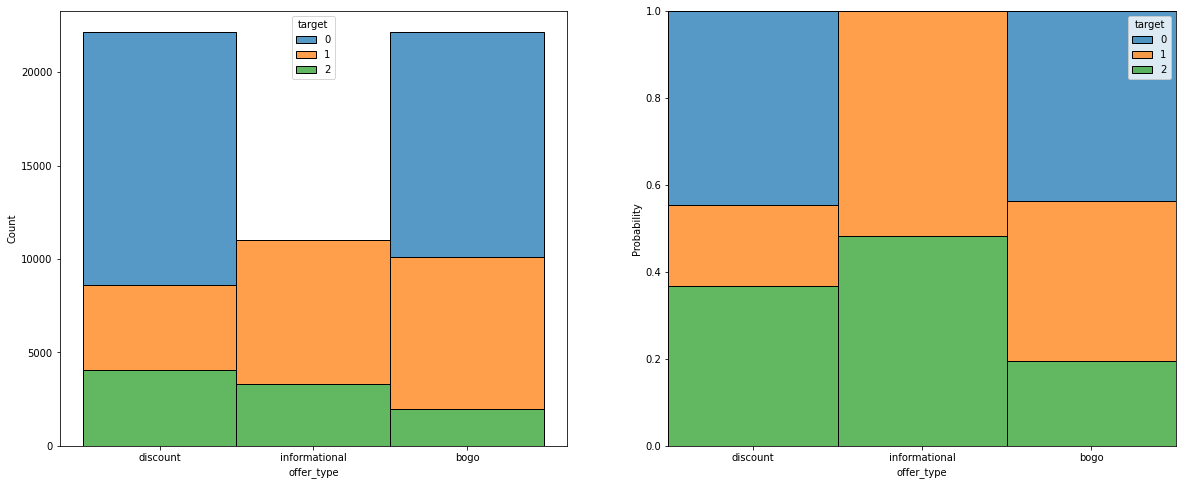

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=data, x="offer_type", hue="target", stat="count", multiple="stack", palette="tab10", ax=ax1)
sns.histplot(data=data, x="offer_type", hue="target",  stat="probability", multiple="fill", palette="tab10", common_norm=False, ax=ax2)

### membership

<AxesSubplot:xlabel='membership', ylabel='Probability'>

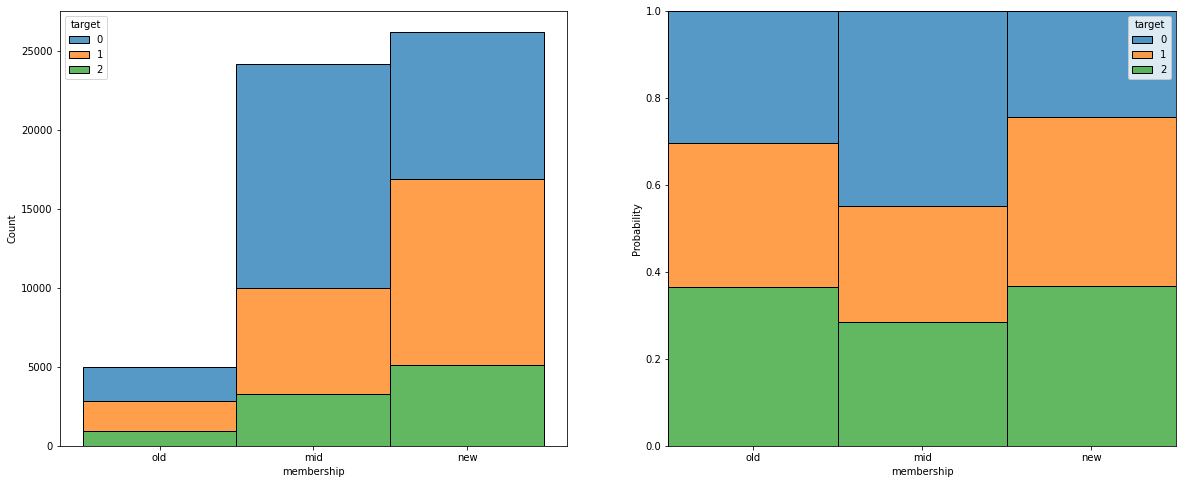

In [125]:
df = data[["membership", "target"]].copy()
df["membership_order"] = df["membership"].map({"old": 0, "mid": 1, "new": 2})
df = df.sort_values("membership_order")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=df, x="membership", hue="target", stat="count", multiple="stack", palette="tab10", ax=ax1)
sns.histplot(data=df, x="membership", hue="target",  stat="probability", multiple="fill", palette="tab10", common_norm=False, ax=ax2)

### age_bucket

<AxesSubplot:xlabel='age_bucket', ylabel='Probability'>

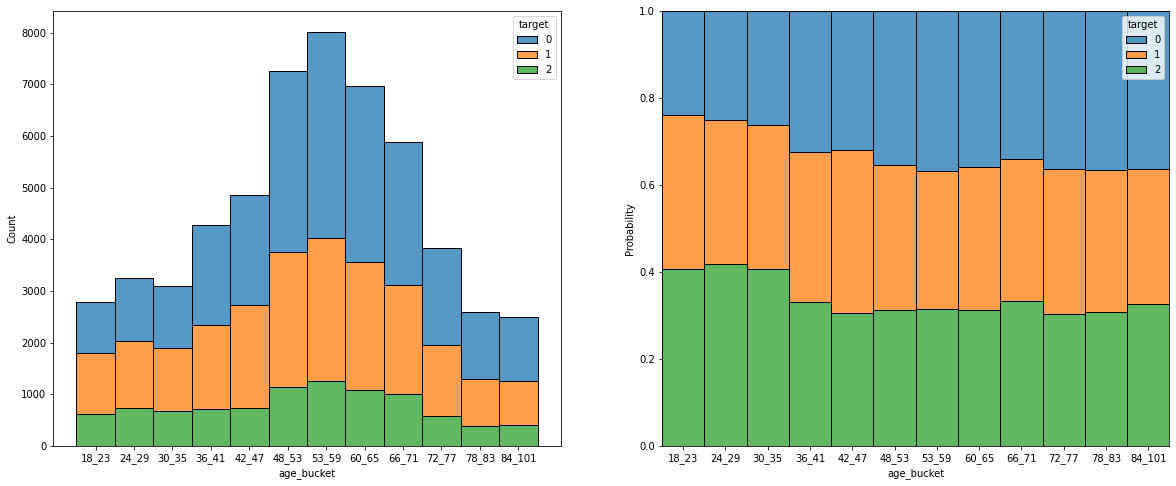

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=data.sort_values("age_bucket"), x="age_bucket", hue="target", stat="count", multiple="stack", palette="tab10", ax=ax1)
sns.histplot(data=data.sort_values("age_bucket"), x="age_bucket", hue="target",  stat="probability", multiple="fill", palette="tab10", common_norm=False, ax=ax2)

### income_bucket

<AxesSubplot:xlabel='income_bucket', ylabel='Probability'>

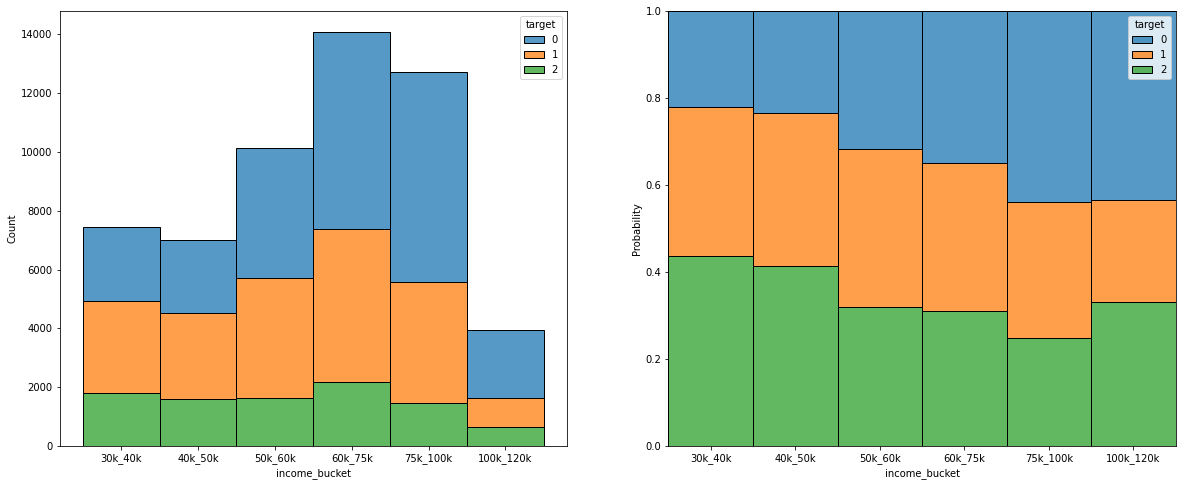

In [127]:
df = data[["income_bucket", "target"]].copy()
df["income_order"] = df["income_bucket"].apply(lambda x: int(x.split("k")[0]))
df = df.sort_values("income_order")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=df, x="income_bucket", hue="target", stat="count", multiple="stack", palette="tab10", ax=ax1)
sns.histplot(data=df, x="income_bucket", hue="target",  stat="probability", multiple="fill", palette="tab10", common_norm=False, ax=ax2)

### gender

<AxesSubplot:xlabel='gender', ylabel='Probability'>

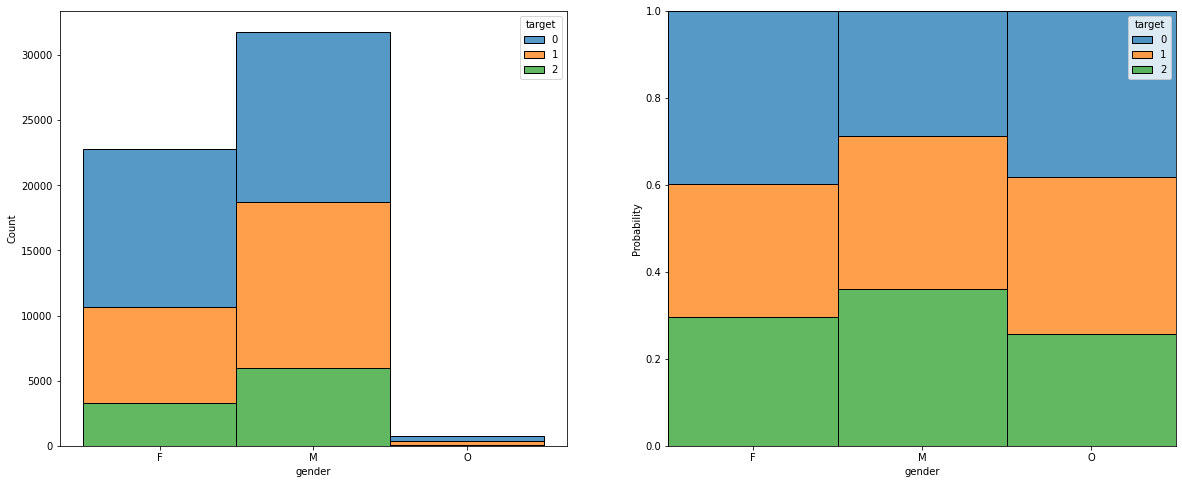

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=data.sort_values("gender"), x="gender", hue="target", stat="count", multiple="stack", palette="tab10", ax=ax1)
sns.histplot(data=data.sort_values("gender"), x="gender", hue="target",  stat="probability", multiple="fill", palette="tab10", common_norm=False, ax=ax2)

### being a NULL Profile

<AxesSubplot:xlabel='was_null_profile', ylabel='Probability'>

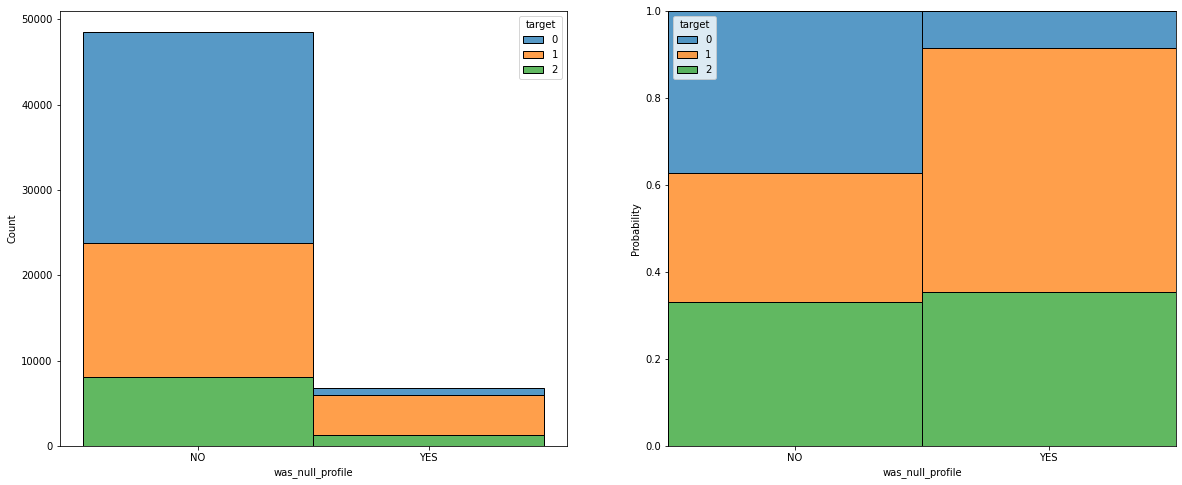

In [129]:
df = data[["was_null_profile", "target"]].copy()
df["was_null_profile"] = df["was_null_profile"].map({0: "NO", 1:"YES"})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=df.sort_values("was_null_profile"), x="was_null_profile", hue="target", stat="count", multiple="stack", discrete=True, palette="tab10", ax=ax1)
sns.histplot(data=df.sort_values("was_null_profile"), x="was_null_profile", hue="target",  stat="probability", multiple="fill", discrete=True, palette="tab10", common_norm=False, ax=ax2)

### time_after_last_trans

<AxesSubplot:xlabel='time_after_last_trans', ylabel='Probability'>

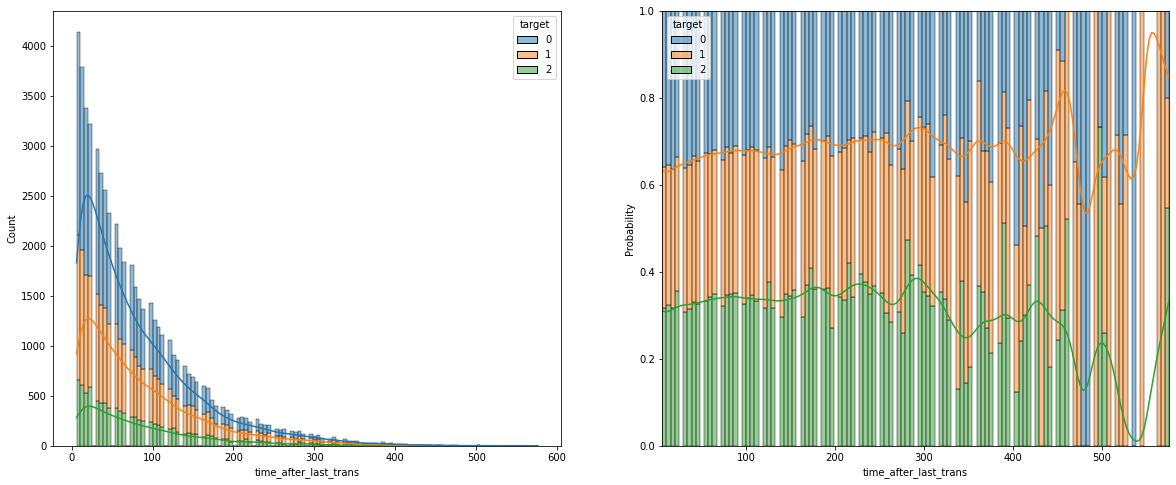

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=data, x="time_after_last_trans", hue="target", stat="count", multiple="stack", palette="tab10", kde=True, ax=ax1)
sns.histplot(data=data, x="time_after_last_trans", hue="target",  stat="probability", multiple="fill", palette="tab10", common_norm=False, kde=True, ax=ax2)

### avg_trans_amount

<AxesSubplot:xlabel='avg_trans_amount', ylabel='Probability'>

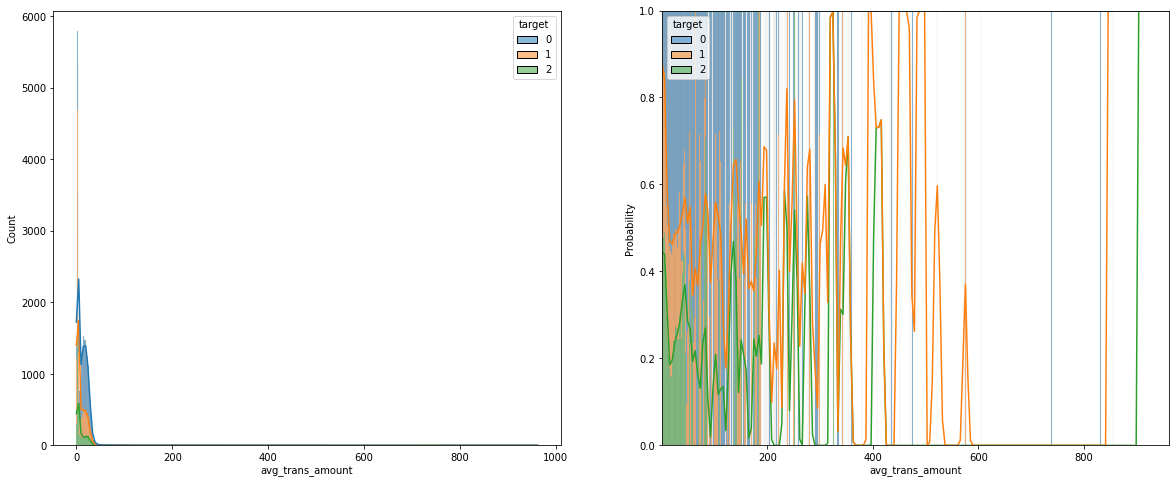

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=data, x="avg_trans_amount", hue="target", stat="count", multiple="stack", palette="tab10", kde=True, ax=ax1)
sns.histplot(data=data, x="avg_trans_amount", hue="target",  stat="probability", multiple="fill",  palette="tab10", common_norm=False, kde=True, ax=ax2)

### difficulty

<AxesSubplot:xlabel='difficulty', ylabel='Probability'>

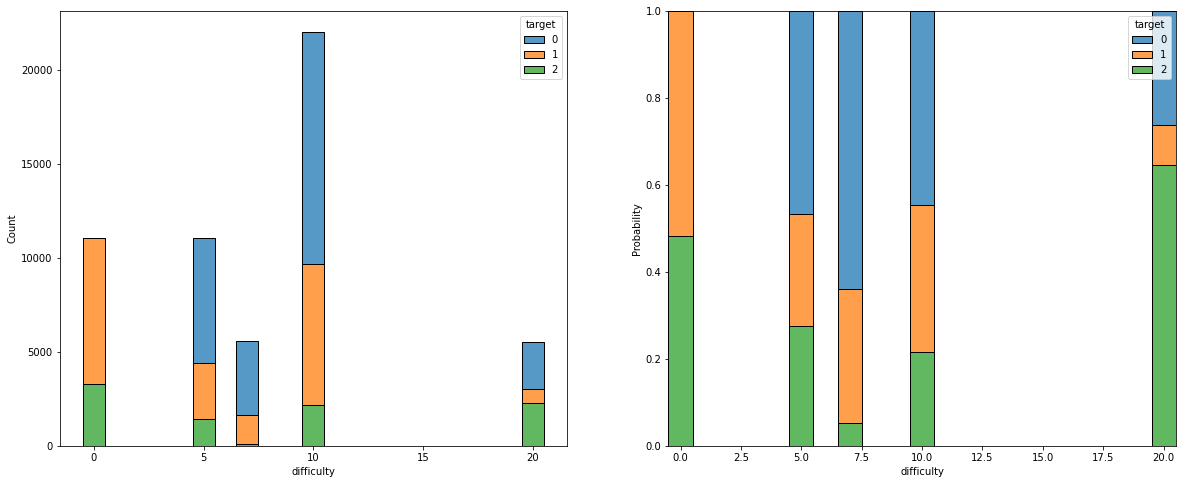

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=data, x="difficulty", hue="target", stat="count", multiple="stack", discrete=True, palette="tab10", ax=ax1)
sns.histplot(data=data, x="difficulty", hue="target",  stat="probability", multiple="fill", discrete=True, palette="tab10", common_norm=False, ax=ax2)

### channels

<AxesSubplot:xlabel='wms', ylabel='Probability'>

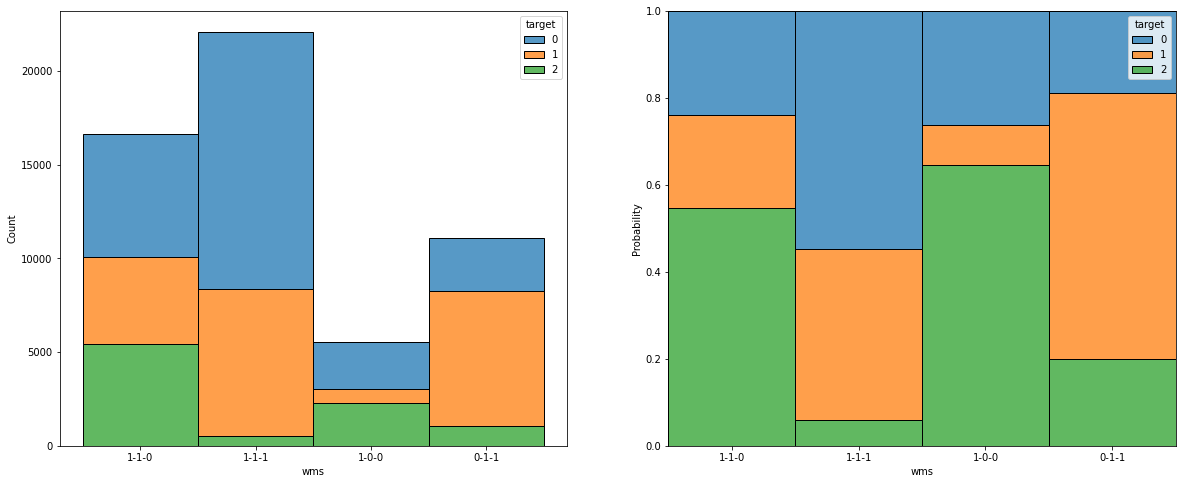

In [133]:
df = data[["web", "mobile", "social", "target"]].copy()
df["wms"] = df["web"].astype(str) + "-" + df["mobile"].astype(str) + "-" + df["social"].astype(str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=df, x="wms", hue="target", stat="count", multiple="stack", discrete=True, palette="tab10", ax=ax1)
sns.histplot(data=df, x="wms", hue="target",  stat="probability", multiple="fill", discrete=True, palette="tab10", common_norm=False, ax=ax2)

### recurrence

<AxesSubplot:xlabel='recurrence', ylabel='Probability'>

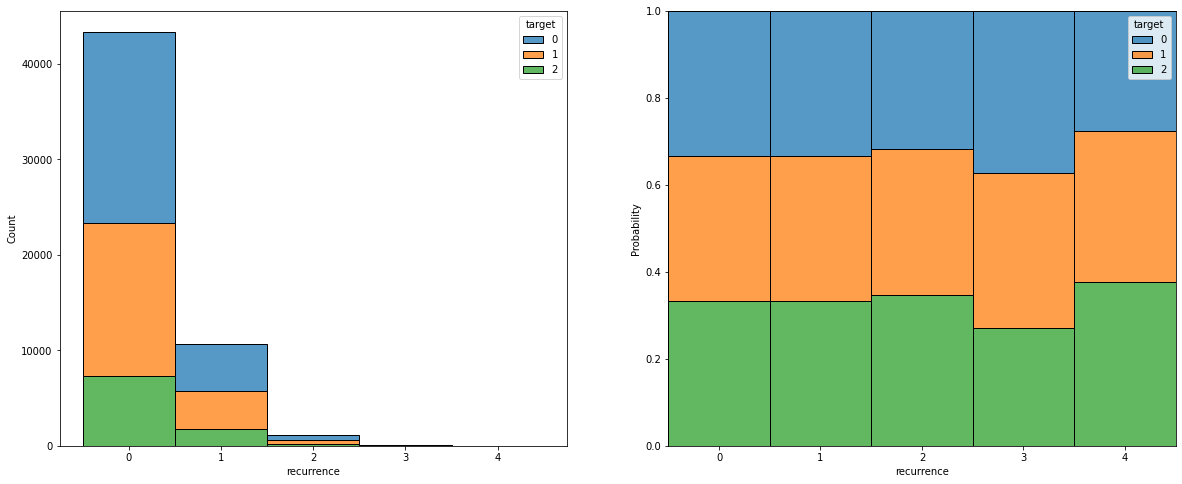

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data=data, x="recurrence", hue="target", stat="count", multiple="stack", discrete=True, palette="tab10", ax=ax1)
sns.histplot(data=data, x="recurrence", hue="target",  stat="probability", multiple="fill", discrete=True, palette="tab10", common_norm=False, ax=ax2)

There are several conclusions:
- Offer completion probability of mid-level members are slightly higher. 
- As age increases, offer completion probability increases.
- As income increases, similar to age, offer completion probability increases.
- Hence the time difference increases, offer view probability increases.
- Mobile and social channels have a significant impact on offer completion. 
- Recurrence has no significant effect on the distribution of the target.
- NULL profile customer's offer completion probability is lower than NOT NULL.

Infinitely many analysis can be made for intuition. At that point, ML Algorithms shine. They provide us better insight on the data.

## Categorical Variable Transformation - One-Hot-Encoding 

In [135]:
data.dtypes

customer_id               object
offer_id                  object
recurrence                 int64
received                   int64
target                     int64
time                     float64
amount                   float64
total_trans_amount       float64
total_trans_count        float64
avg_trans_amount         float64
time_after_last_trans    float64
offer_type                object
difficulty                 int64
duration                   int64
reward                     int64
web                        int64
mobile                     int64
social                     int64
membership                object
gender                    object
age_bucket                object
income_bucket             object
was_null_profile           int64
dtype: object

In [136]:
data.nunique()

customer_id              16183
offer_id                    10
recurrence                   5
received                     5
target                       3
time                        96
amount                    4221
total_trans_amount       21580
total_trans_count           28
avg_trans_amount         18832
time_after_last_trans       93
offer_type                   3
difficulty                   5
duration                     5
reward                       5
web                          2
mobile                       2
social                       2
membership                   3
gender                       3
age_bucket                  12
income_bucket                6
was_null_profile             2
dtype: int64

- Index Variables
    - customer_id
    - offer_id
    - received
- Categorical Variables:
    - offer_type
    - difficulty
    - duration
    - reward
    - membership
    - gender
    - age_bucket
    - income_bucket
- Ordinal Variables:
    - recurrence
    - total_trans_count

In [137]:
prefix_dict = {
    "offer_type": "oft", 
    "difficulty": "dfc",
    "duration": "delta",
    "reward": "rw",
    "membership": "member",
    "gender": "gen",
    "age_bucket": "age",
    "income_bucket": "income"
}

data_ = data.copy()

for key, value in prefix_dict.items():
    dum = pd.get_dummies(data[key], prefix=value)
    data_ = data_.join(dum)
    data_ = data_.drop(columns=[key], axis=1)
    
data_.sample(3).T

,27322,8750,48994
customer_id,7e5b86cde767403b85683543c5183817,2a2c5ee51e784e0bb4a956a4d36ae159,e23280a162b34a94a7b45ce5d9b18b7a
offer_id,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,9b98b8c7a33c4b65b9aebfe6a799e6d9
recurrence,1,1,0
received,576,576,336
target,1,0,0
time,534.0,528.0,228.0
amount,6.06,6.16,45.74
total_trans_amount,58.18,55.7,159.53
total_trans_count,19.0,10.0,6.0
avg_trans_amount,3.062,5.57,26.588


In [138]:
data.nunique()

customer_id              16183
offer_id                    10
recurrence                   5
received                     5
target                       3
time                        96
amount                    4221
total_trans_amount       21580
total_trans_count           28
avg_trans_amount         18832
time_after_last_trans       93
offer_type                   3
difficulty                   5
duration                     5
reward                       5
web                          2
mobile                       2
social                       2
membership                   3
gender                       3
age_bucket                  12
income_bucket                6
was_null_profile             2
dtype: int64

In [139]:
data_ = data_.set_index(data_["customer_id"] + "-" + data_["offer_id"] + "-" + data_["recurrence"].astype(str))
data = data_.drop(columns=["customer_id", "offer_id", "received"], axis=1)

data.head().T

,0009655768c64bdeb2e877511632db8f-2906b810c7d4411798c6938adc9daaa5-0,0009655768c64bdeb2e877511632db8f-3f207df678b143eea3cee63160fa8bed-0,0009655768c64bdeb2e877511632db8f-f19421c1d4aa40978ebb69ca19b0e20d-0,0009655768c64bdeb2e877511632db8f-fafdcd668e3743c1bb461111dcafc2a4-0,00116118485d4dfda04fdbaba9a87b5c-f19421c1d4aa40978ebb69ca19b0e20d-1
recurrence,0.00,0.00,0.00,0.000,1.000
target,0.00,1.00,0.00,0.000,1.000
time,552.00,228.00,228.00,414.000,474.000
amount,13.56,22.16,22.16,8.570,3.190
total_trans_amount,58.40,22.16,22.16,30.730,4.090
total_trans_count,4.00,1.00,1.00,2.000,3.000
avg_trans_amount,14.60,22.16,22.16,15.365,1.363
time_after_last_trans,24.00,108.00,180.00,90.000,102.000
web,1.00,1.00,1.00,1.000,1.000
mobile,1.00,1.00,1.00,1.000,1.000


In [140]:
data.dtypes

recurrence                 int64
target                     int64
time                     float64
amount                   float64
total_trans_amount       float64
total_trans_count        float64
avg_trans_amount         float64
time_after_last_trans    float64
web                        int64
mobile                     int64
social                     int64
was_null_profile           int64
oft_bogo                   uint8
oft_discount               uint8
oft_informational          uint8
dfc_0                      uint8
dfc_5                      uint8
dfc_7                      uint8
dfc_10                     uint8
dfc_20                     uint8
delta_3                    uint8
delta_4                    uint8
delta_5                    uint8
delta_7                    uint8
delta_10                   uint8
rw_0                       uint8
rw_2                       uint8
rw_3                       uint8
rw_5                       uint8
rw_10                      uint8
member_mid

In [141]:
#dtype correction
data["time"] = data["time"].astype(int)
data["time_after_last_trans"] = data["time_after_last_trans"].astype(int)
data["total_trans_count"] = data["total_trans_count"].astype(int)

data.dtypes

recurrence                 int64
target                     int64
time                       int64
amount                   float64
total_trans_amount       float64
total_trans_count          int64
avg_trans_amount         float64
time_after_last_trans      int64
web                        int64
mobile                     int64
social                     int64
was_null_profile           int64
oft_bogo                   uint8
oft_discount               uint8
oft_informational          uint8
dfc_0                      uint8
dfc_5                      uint8
dfc_7                      uint8
dfc_10                     uint8
dfc_20                     uint8
delta_3                    uint8
delta_4                    uint8
delta_5                    uint8
delta_7                    uint8
delta_10                   uint8
rw_0                       uint8
rw_2                       uint8
rw_3                       uint8
rw_5                       uint8
rw_10                      uint8
member_mid

## Correlation Analysis

In [142]:
corr_df = data.corr().stack().rename("coeff").reset_index()
corr_df.head()

,level_0,level_1,coeff
0,recurrence,recurrence,1.000000
1,recurrence,target,0.001186
2,recurrence,time,0.191388
3,recurrence,amount,-0.002455
4,recurrence,total_trans_amount,0.058519


In [143]:
corr_df = corr_df[corr_df["level_0"] != corr_df["level_1"]].reset_index(drop=True)

corr_df[corr_df["coeff"] > 0.7].sort_values("coeff", ascending=False)

,level_0,level_1,coeff
756,oft_informational,dfc_0,1.000000
766,oft_informational,rw_0,1.000000
809,dfc_0,oft_informational,1.000000
819,dfc_0,rw_0,1.000000
927,dfc_7,rw_3,1.000000
1339,rw_0,oft_informational,1.000000
1340,rw_0,dfc_0,1.000000
1448,rw_3,dfc_7,1.000000
875,dfc_5,rw_5,0.763328
1500,rw_5,dfc_5,0.763328


In [144]:
corr_df[corr_df["coeff"] < -0.7].sort_values("coeff")

,level_0,level_1,coeff
495,mobile,dfc_20,-1.000000
1016,dfc_20,mobile,-1.000000
1782,gen_F,gen_M,-0.971914
1835,gen_M,gen_F,-0.971914
1620,member_mid,member_new,-0.835142
1673,member_new,member_mid,-0.835142


### Correlated Features
    
    - dfc_0, oft_informational, rw_0: reward information indicates both offer type and difficulty. 
        - oft_informational and dfc_0 will be dropped. 
        
    - dfc_7, rw_3:  reward information indicates dfc_7.
        - dfc_7 will be dropped.
       
    - dfc_20, mobile:  mobile information indicates dfc_20.
        - dfc_20 will be dropped.
        
    - gen_F, gen_M: inverse correlation - Male-Female are complement of each other in general.
        - gen_M will be dropped.
        
    - member_mid, member_new: inverse correlation. 
        - member_mid will be dropped

In [145]:
drop_cols = ["oft_informational", "dfc_0", "dfc_7", "dfc_20", "gen_M", "member_mid"]
data = data.drop(columns=drop_cols, axis=1)

data.head().T

,0009655768c64bdeb2e877511632db8f-2906b810c7d4411798c6938adc9daaa5-0,0009655768c64bdeb2e877511632db8f-3f207df678b143eea3cee63160fa8bed-0,0009655768c64bdeb2e877511632db8f-f19421c1d4aa40978ebb69ca19b0e20d-0,0009655768c64bdeb2e877511632db8f-fafdcd668e3743c1bb461111dcafc2a4-0,00116118485d4dfda04fdbaba9a87b5c-f19421c1d4aa40978ebb69ca19b0e20d-1
recurrence,0.00,0.00,0.00,0.000,1.000
target,0.00,1.00,0.00,0.000,1.000
time,552.00,228.00,228.00,414.000,474.000
amount,13.56,22.16,22.16,8.570,3.190
total_trans_amount,58.40,22.16,22.16,30.730,4.090
total_trans_count,4.00,1.00,1.00,2.000,3.000
avg_trans_amount,14.60,22.16,22.16,15.365,1.363
time_after_last_trans,24.00,108.00,180.00,90.000,102.000
web,1.00,1.00,1.00,1.000,1.000
mobile,1.00,1.00,1.00,1.000,1.000


### MinMax Scaling

In [146]:
_ = data.describe().loc[["min", "max"]].T

_[(_["min"] != 0) | (_["max"] != 1)]

,min,max
recurrence,0.00,4.00
target,0.00,2.00
time,0.00,570.00
amount,0.05,1001.85
total_trans_amount,0.05,1325.72
total_trans_count,1.00,29.00
avg_trans_amount,0.05,962.10
time_after_last_trans,6.00,576.00


There are 7 variables to scale to [0, 1] - Target defines the classes.

In [147]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_list = ['recurrence', 'time', 'amount', 'total_trans_amount', 
              'total_trans_count', 'avg_trans_amount', 'time_after_last_trans']

for col in scale_list:
    data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))

In [148]:
data.describe().loc[["min", "max"]].T

,min,max
recurrence,0.0,1.0
target,0.0,2.0
time,0.0,1.0
amount,0.0,1.0
total_trans_amount,0.0,1.0
total_trans_count,0.0,1.0
avg_trans_amount,0.0,1.0
time_after_last_trans,0.0,1.0
web,0.0,1.0
mobile,0.0,1.0


# Train - Test Split

- The data is splitted into two subsets: Train and Test. Train has 80% of the samples of main data, whereas Test has 15%. <br>
- Models will be trained by Train and optimized with Cross-Validation. Test set will be used for evaluation. 

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)

train.to_csv("../data/processed/train.csv", index=True, header=True)
test.to_csv("../data/processed/test.csv", index=True, header=True)

----

# AWS

### Upload Data to S3

In [ ]:
import boto3
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = "bucket"
data_dir = '../data/processed'
prefix = "data"

# upload data to S3
sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

### Check S3 bucket

In [ ]:
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'